# Yoututbe Data Preprocessing, Sentiment Analysis, and Topic Modeling and Visualization

## Initial Setup

In [1]:
# Importing libraries
import re
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
from wordcloud import WordCloud
from collections import Counter


# Importing Scikit-learn libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Importing Gensim libraries
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Importing NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# Downloading NLTK stopwords
nltk.download('stopwords')
# Downloading NLTK vader lexicon
nltk.download('vader_lexicon')
# Downloading NLTK punkt tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-v0_8")

# Setting aesthetic parameters for plots
sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

In [3]:
merged_data_path = '../Data/merged_youtube_data.json'

with open(merged_data_path, 'r') as file:
    merged_data = json.load(file)

records = []
# Extract all video records from the merged data and comment data and replies data
for video in merged_data:
    title = video.get('title', '')
    desc = video.get('description', '')
    
    # First row: title + description
    records.append({
        'videoId': video.get('videoId', ''),
        'text': f"{title}\n\n{desc}",
        'title': title,
        'description': desc,
        'channelTitle': video.get('channelTitle', ''),
        'videoPublishedAt': video.get('videoPublishedAt', ''),
        'tags': video.get('tags', []),
        'viewCount':  video.get('viewCount', 0),
        'videoLikeCount': video.get('videoLikeCount', 0),
        'videoCommentCount': video.get('videoCommentCount', 0),
        'type': 'video'
    })
    for comment in video.get('comments', []):
        comment_text = comment.get('text', '')
        records.append({
            'videoId': video.get('videoId', ''),
            "commentId": comment.get('commentId', ''),
            "author":  comment.get('author', ''),
            "text": comment_text, 
            "likeCount": comment.get('likeCount', 0), 
            "publishedAt": comment.get('publishedAt', ''), 
            "parentId": comment.get('parentId', ''),
            "authorChannelId":  comment.get('authorChannelId', ''),
            "type": 'comment',
        })
        if len(comment.get('replies', [])) > 0:
            comment['replies'] = comment['replies']
            for reply in comment.get('replies', []):
                reply_text = reply.get('text', '')
                records.append({
                    'videoId': video.get('videoId', ''),
                    "commentId": reply.get('commentId', ''),
                    "author":  reply.get('author', ''),
                    "text": reply_text, 
                    "likeCount": reply.get('likeCount', 0), 
                    "publishedAt": reply.get('publishedAt', ''), 
                    "parentId": reply.get('parentId', ''),
                    "authorChannelId":  reply.get('authorChannelId', ''),
                    "type": 'reply',
                })

df = pd.DataFrame(records)


In [4]:
df.head()

videoId                                               text  \
0  x_DyyPMaVR0  Russia-Ukraine: Trump calls Putin 'crazy’ afte...   
1  x_DyyPMaVR0  Yet no mention of the fact that in the recent ...   
2  x_DyyPMaVR0  Trump talks a lot but none of it ever transfor...   
3  x_DyyPMaVR0  Haaha the russian bots are terrified. Just bas...   
4  x_DyyPMaVR0                    send the troops president trump   

                                               title  \
0  Russia-Ukraine: Trump calls Putin 'crazy’ afte...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         description    channelTitle  \
0  In Ukraine, swarms of Russian drones filled th...  Channel 4 News   
1                                                NaN             NaN   
2                                                NaN             NaN   
3                                                NaN             NaN   
4                                                NaN             NaN   

       videoPublishedAt                                               tags  \
0  2025-05-26T17:50:04Z  Russia;Ukraine;Turkey;Ankara;Russia Ukraine Wa...   
1                   NaN                                                NaN   
2                   NaN                                                NaN   
3                   NaN                                                NaN   
4                   NaN                                                NaN   

  viewCount videoLikeCount videoCommentCount     type  \
0     62099            544               455    video   
1       NaN            NaN               NaN  comment   
2       NaN            NaN               NaN  comment   
3       NaN            NaN               NaN  comment   
4       NaN            NaN               NaN  comment   

                    commentId          author  likeCount  \
0                         NaN             NaN        NaN   
1  UgyYRQsBSosygi4eLNF4AaABAg  @richieboy1971        0.0   
2  UgzbI_K-OCQ6Baxyw-J4AaABAg     @Turtle_Zed        0.0   
3  UgzE02o83Kt_RW3_x054AaABAg       @Vykandar        0.0   
4  Ugy_5MssCvruQIlLRBR4AaABAg  @stmartinshirt        0.0   

            publishedAt parentId           authorChannelId  
0                   NaN      NaN                       NaN  
1  2025-05-27T04:41:25Z     None  UCqaL9sb-wqAKneSzwju92OA  
2  2025-05-27T04:34:40Z     None  UCNImr4HOMoOBjb3Y0MUW-Uw  
3  2025-05-27T04:30:09Z     None  UC92JUclfl0YcAqK4xlpRc_w  
4  2025-05-27T04:29:53Z     None  UC_hAirOy_3qohESaQ0P6ttg

In [5]:
df.dtypes

videoId               object
text                  object
title                 object
description           object
channelTitle          object
videoPublishedAt      object
tags                  object
viewCount             object
videoLikeCount        object
videoCommentCount     object
type                  object
commentId             object
author                object
likeCount            float64
publishedAt           object
parentId              object
authorChannelId       object
dtype: object

In [6]:
# Define the data types of the columns
df['viewCount'] = pd.to_numeric(df['viewCount'], errors='coerce')
df['videoLikeCount'] = pd.to_numeric(df['videoLikeCount'], errors='coerce')
df['videoCommentCount'] = pd.to_numeric(df['videoCommentCount'], errors='coerce')
df['likeCount'] = pd.to_numeric(df['likeCount'], errors='coerce')
df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')
df['videoPublishedAt'] = pd.to_datetime(df['videoPublishedAt'], errors='coerce')
df['text'] = df['text'].astype(str)
df['title'] = df['title'].astype(str)
df['description'] = df['description'].astype(str)
df['channelTitle'] = df['channelTitle'].astype(str)
df['type'] = df['type'].astype(str)
df.dtypes

videoId                           object
text                              object
title                             object
description                       object
channelTitle                      object
videoPublishedAt     datetime64[ns, UTC]
tags                              object
viewCount                        float64
videoLikeCount                   float64
videoCommentCount                float64
type                              object
commentId                         object
author                            object
likeCount                        float64
publishedAt          datetime64[ns, UTC]
parentId                          object
authorChannelId                   object
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51254 entries, 0 to 51253
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   videoId            51254 non-null  object             
 1   text               51254 non-null  object             
 2   title              51254 non-null  object             
 3   description        51254 non-null  object             
 4   channelTitle       51254 non-null  object             
 5   videoPublishedAt   175 non-null    datetime64[ns, UTC]
 6   tags               175 non-null    object             
 7   viewCount          175 non-null    float64            
 8   videoLikeCount     174 non-null    float64            
 9   videoCommentCount  175 non-null    float64            
 10  type               51254 non-null  object             
 11  commentId          51079 non-null  object             
 12  author             51079 non-null  object     

In [8]:
df.describe()

viewCount  videoLikeCount  videoCommentCount     likeCount
count  1.750000e+02      174.000000          175.00000  51079.000000
mean   1.475762e+05     2803.827586          479.60000      2.760175
std    3.517949e+05     5780.746180          945.02162     16.025037
min    9.940000e+02       22.000000           10.00000      0.000000
25%    2.374500e+04      288.000000           41.00000      0.000000
50%    5.164800e+04      773.000000          126.00000      0.000000
75%    1.578670e+05     2906.500000          449.50000      1.000000
max    3.978011e+06    41734.000000         6808.00000    857.000000

In [9]:
df.shape

(51254, 17)

## Data Preprocessing

In [10]:
tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

# Basic cleaning & abbreviation setup
abbreviations = {
    "lol": "laugh out loud", "omg": "oh my god", "idk": "i don't know",
    "rn": "right now", "u": "you", "ur": "your", "btw": "by the way",
    "brb": "be right back", "thx": "thanks", "pls": "please", "imo": "in my opinion",
    "fwiw": "for what it's worth", "lmao": "laughing my ass off"
}

#  Clean + tokenize + stem function
def process_text(text):
    if not text or not isinstance(text, str):
        return []

    # Lowercase, remove zero-width spaces
    text = text.replace('\u200b', '').lower()
 
    # Expand abbreviations
    for abbr, full in abbreviations.items():
        text = re.sub(rf'\b{abbr}\b', full, text)
 
    # Remove URLs and mentions
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove non-ASCII characters (emojis, special symbols)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
 
    # Tokenize
    tokens = tokenizer.tokenize(text)
 
    # Remove stopwords and short tokens
    tokens = [t for t in tokens if len(t) > 1 and t not in stop_words]
 
    # Stemming
    stemmed_tokens = [stemmer.stem(t) for t in tokens if t.isalpha()]
    return stemmed_tokens

df['processed_tokens'] = df['text'].apply(process_text)

In [11]:
# Create word frequency dictionary
all_words = [word for tokens in df['processed_tokens'] for word in tokens]
word_freq = Counter(all_words)

# Remove rare words (frequency = 1)
words_to_keep = {word for word, count in word_freq.items() if count > 1}
df['processed_tokens'] = df['processed_tokens'].apply(
    lambda tokens: [w for w in tokens if w in words_to_keep]
)

In [12]:
# Recreate clean text column after filtering rare words
df['clean_text_filtered'] = df['processed_tokens'].apply(
    lambda tokens: " ".join(tokens)
)

In [13]:
# Display processed data
print("Processed DataFrame:")
print(df[['text', 'processed_tokens', 'clean_text_filtered']].head())


Processed DataFrame:
                                                text  \
0  Russia-Ukraine: Trump calls Putin 'crazy’ afte...   
1  Yet no mention of the fact that in the recent ...   
2  Trump talks a lot but none of it ever transfor...   
3  Haaha the russian bots are terrified. Just bas...   
4                    send the troops president trump   

                                    processed_tokens  \
0  [trump, call, putin, crazi, largest, air, atta...   
1  [yet, mention, fact, recent, negoti, prison, s...   
2  [trump, talk, lot, none, ever, transform, acti...   
3  [russian, bot, terrifi, base, comment, section...   
4                       [send, troop, presid, trump]   

                                 clean_text_filtered  
0  trump call putin crazi largest air attack war ...  
1  yet mention fact recent negoti prison swap ukr...  
2  trump talk lot none ever transform action frie...  
3  russian bot terrifi base comment section tell ...  
4                            s

In [14]:
df.head(5)

videoId                                               text  \
0  x_DyyPMaVR0  Russia-Ukraine: Trump calls Putin 'crazy’ afte...   
1  x_DyyPMaVR0  Yet no mention of the fact that in the recent ...   
2  x_DyyPMaVR0  Trump talks a lot but none of it ever transfor...   
3  x_DyyPMaVR0  Haaha the russian bots are terrified. Just bas...   
4  x_DyyPMaVR0                    send the troops president trump   

                                               title  \
0  Russia-Ukraine: Trump calls Putin 'crazy’ afte...   
1                                                nan   
2                                                nan   
3                                                nan   
4                                                nan   

                                         description    channelTitle  \
0  In Ukraine, swarms of Russian drones filled th...  Channel 4 News   
1                                                nan             nan   
2                                                nan             nan   
3                                                nan             nan   
4                                                nan             nan   

           videoPublishedAt  \
0 2025-05-26 17:50:04+00:00   
1                       NaT   
2                       NaT   
3                       NaT   
4                       NaT   

                                                tags  viewCount  \
0  Russia;Ukraine;Turkey;Ankara;Russia Ukraine Wa...    62099.0   
1                                                NaN        NaN   
2                                                NaN        NaN   
3                                                NaN        NaN   
4                                                NaN        NaN   

   videoLikeCount  videoCommentCount     type                   commentId  \
0           544.0              455.0    video                         NaN   
1             NaN                NaN  comment  UgyYRQsBSosygi4eLNF4AaABAg   
2             NaN                NaN  comment  UgzbI_K-OCQ6Baxyw-J4AaABAg   
3             NaN                NaN  comment  UgzE02o83Kt_RW3_x054AaABAg   
4             NaN                NaN  comment  Ugy_5MssCvruQIlLRBR4AaABAg   

           author  likeCount               publishedAt parentId  \
0             NaN        NaN                       NaT      NaN   
1  @richieboy1971        0.0 2025-05-27 04:41:25+00:00     None   
2     @Turtle_Zed        0.0 2025-05-27 04:34:40+00:00     None   
3       @Vykandar        0.0 2025-05-27 04:30:09+00:00     None   
4  @stmartinshirt        0.0 2025-05-27 04:29:53+00:00     None   

            authorChannelId  \
0                       NaN   
1  UCqaL9sb-wqAKneSzwju92OA   
2  UCNImr4HOMoOBjb3Y0MUW-Uw   
3  UC92JUclfl0YcAqK4xlpRc_w   
4  UC_hAirOy_3qohESaQ0P6ttg   

                                    processed_tokens  \
0  [trump, call, putin, crazi, largest, air, atta...   
1  [yet, mention, fact, recent, negoti, prison, s...   
2  [trump, talk, lot, none, ever, transform, acti...   
3  [russian, bot, terrifi, base, comment, section...   
4                       [send, troop, presid, trump]   

                                 clean_text_filtered  
0  trump call putin crazi largest air attack war ...  
1  yet mention fact recent negoti prison swap ukr...  
2  trump talk lot none ever transform action frie...  
3  russian bot terrifi base comment section tell ...  
4                            send troop presid trump

## Analysis and Visualization

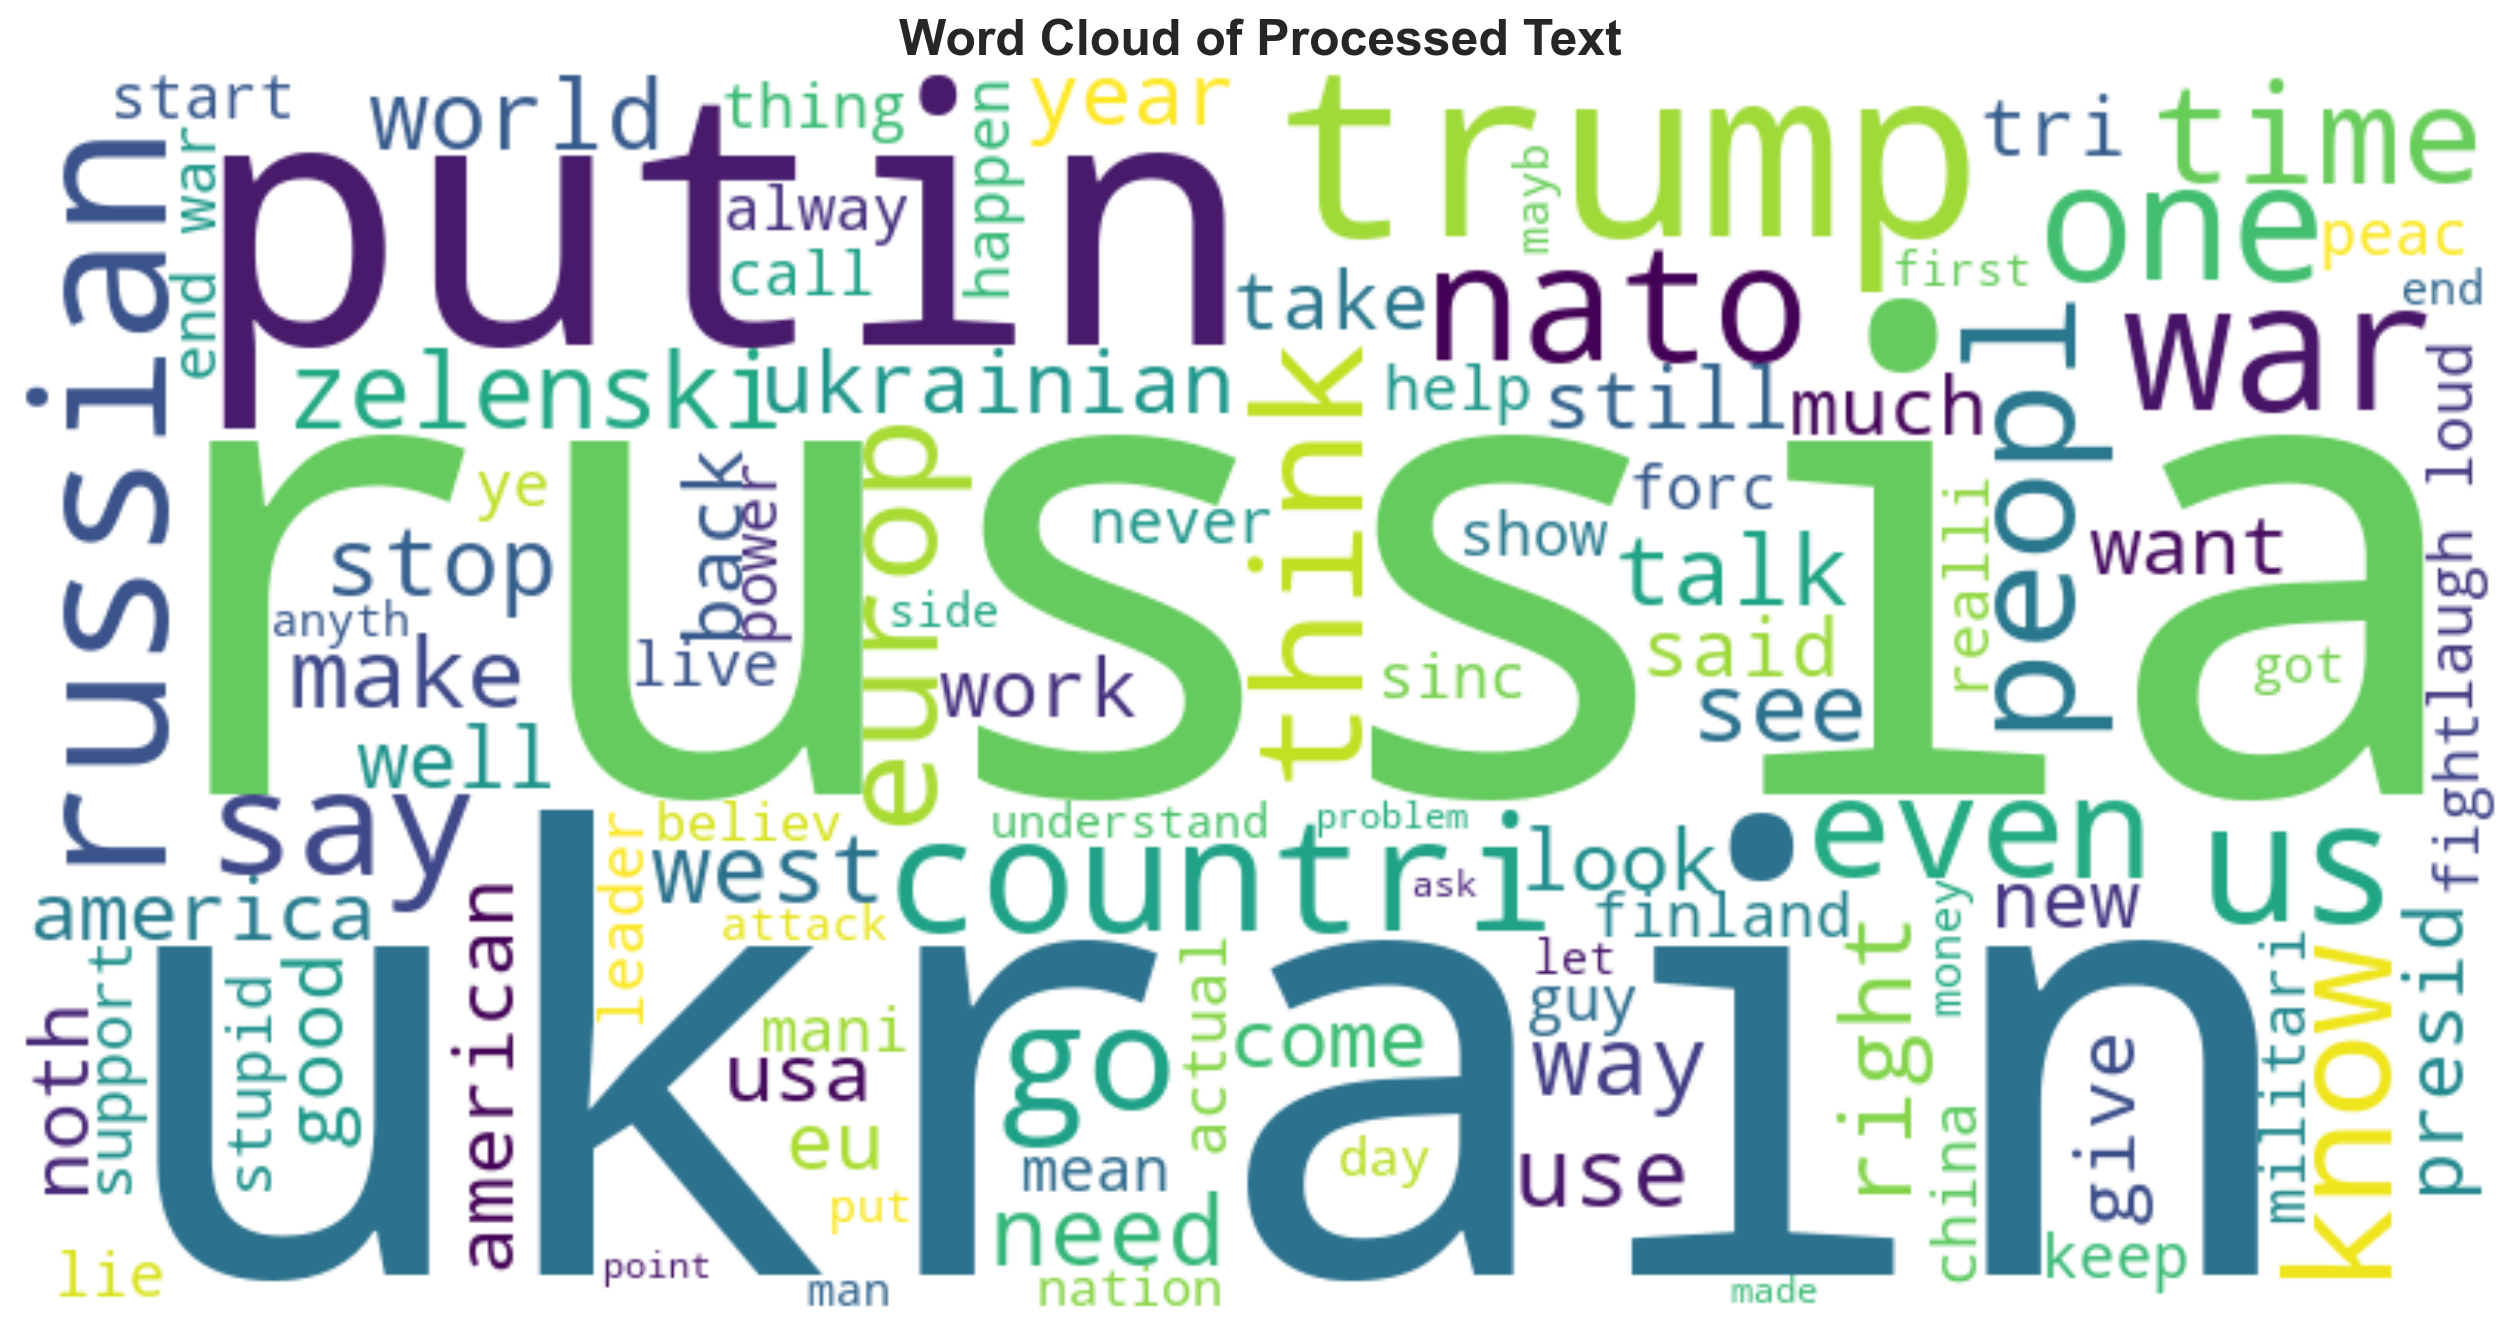

In [15]:
# Word cloud for Processed Text
all_text = " ".join(df['clean_text_filtered'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Processed Text")
plt.show()

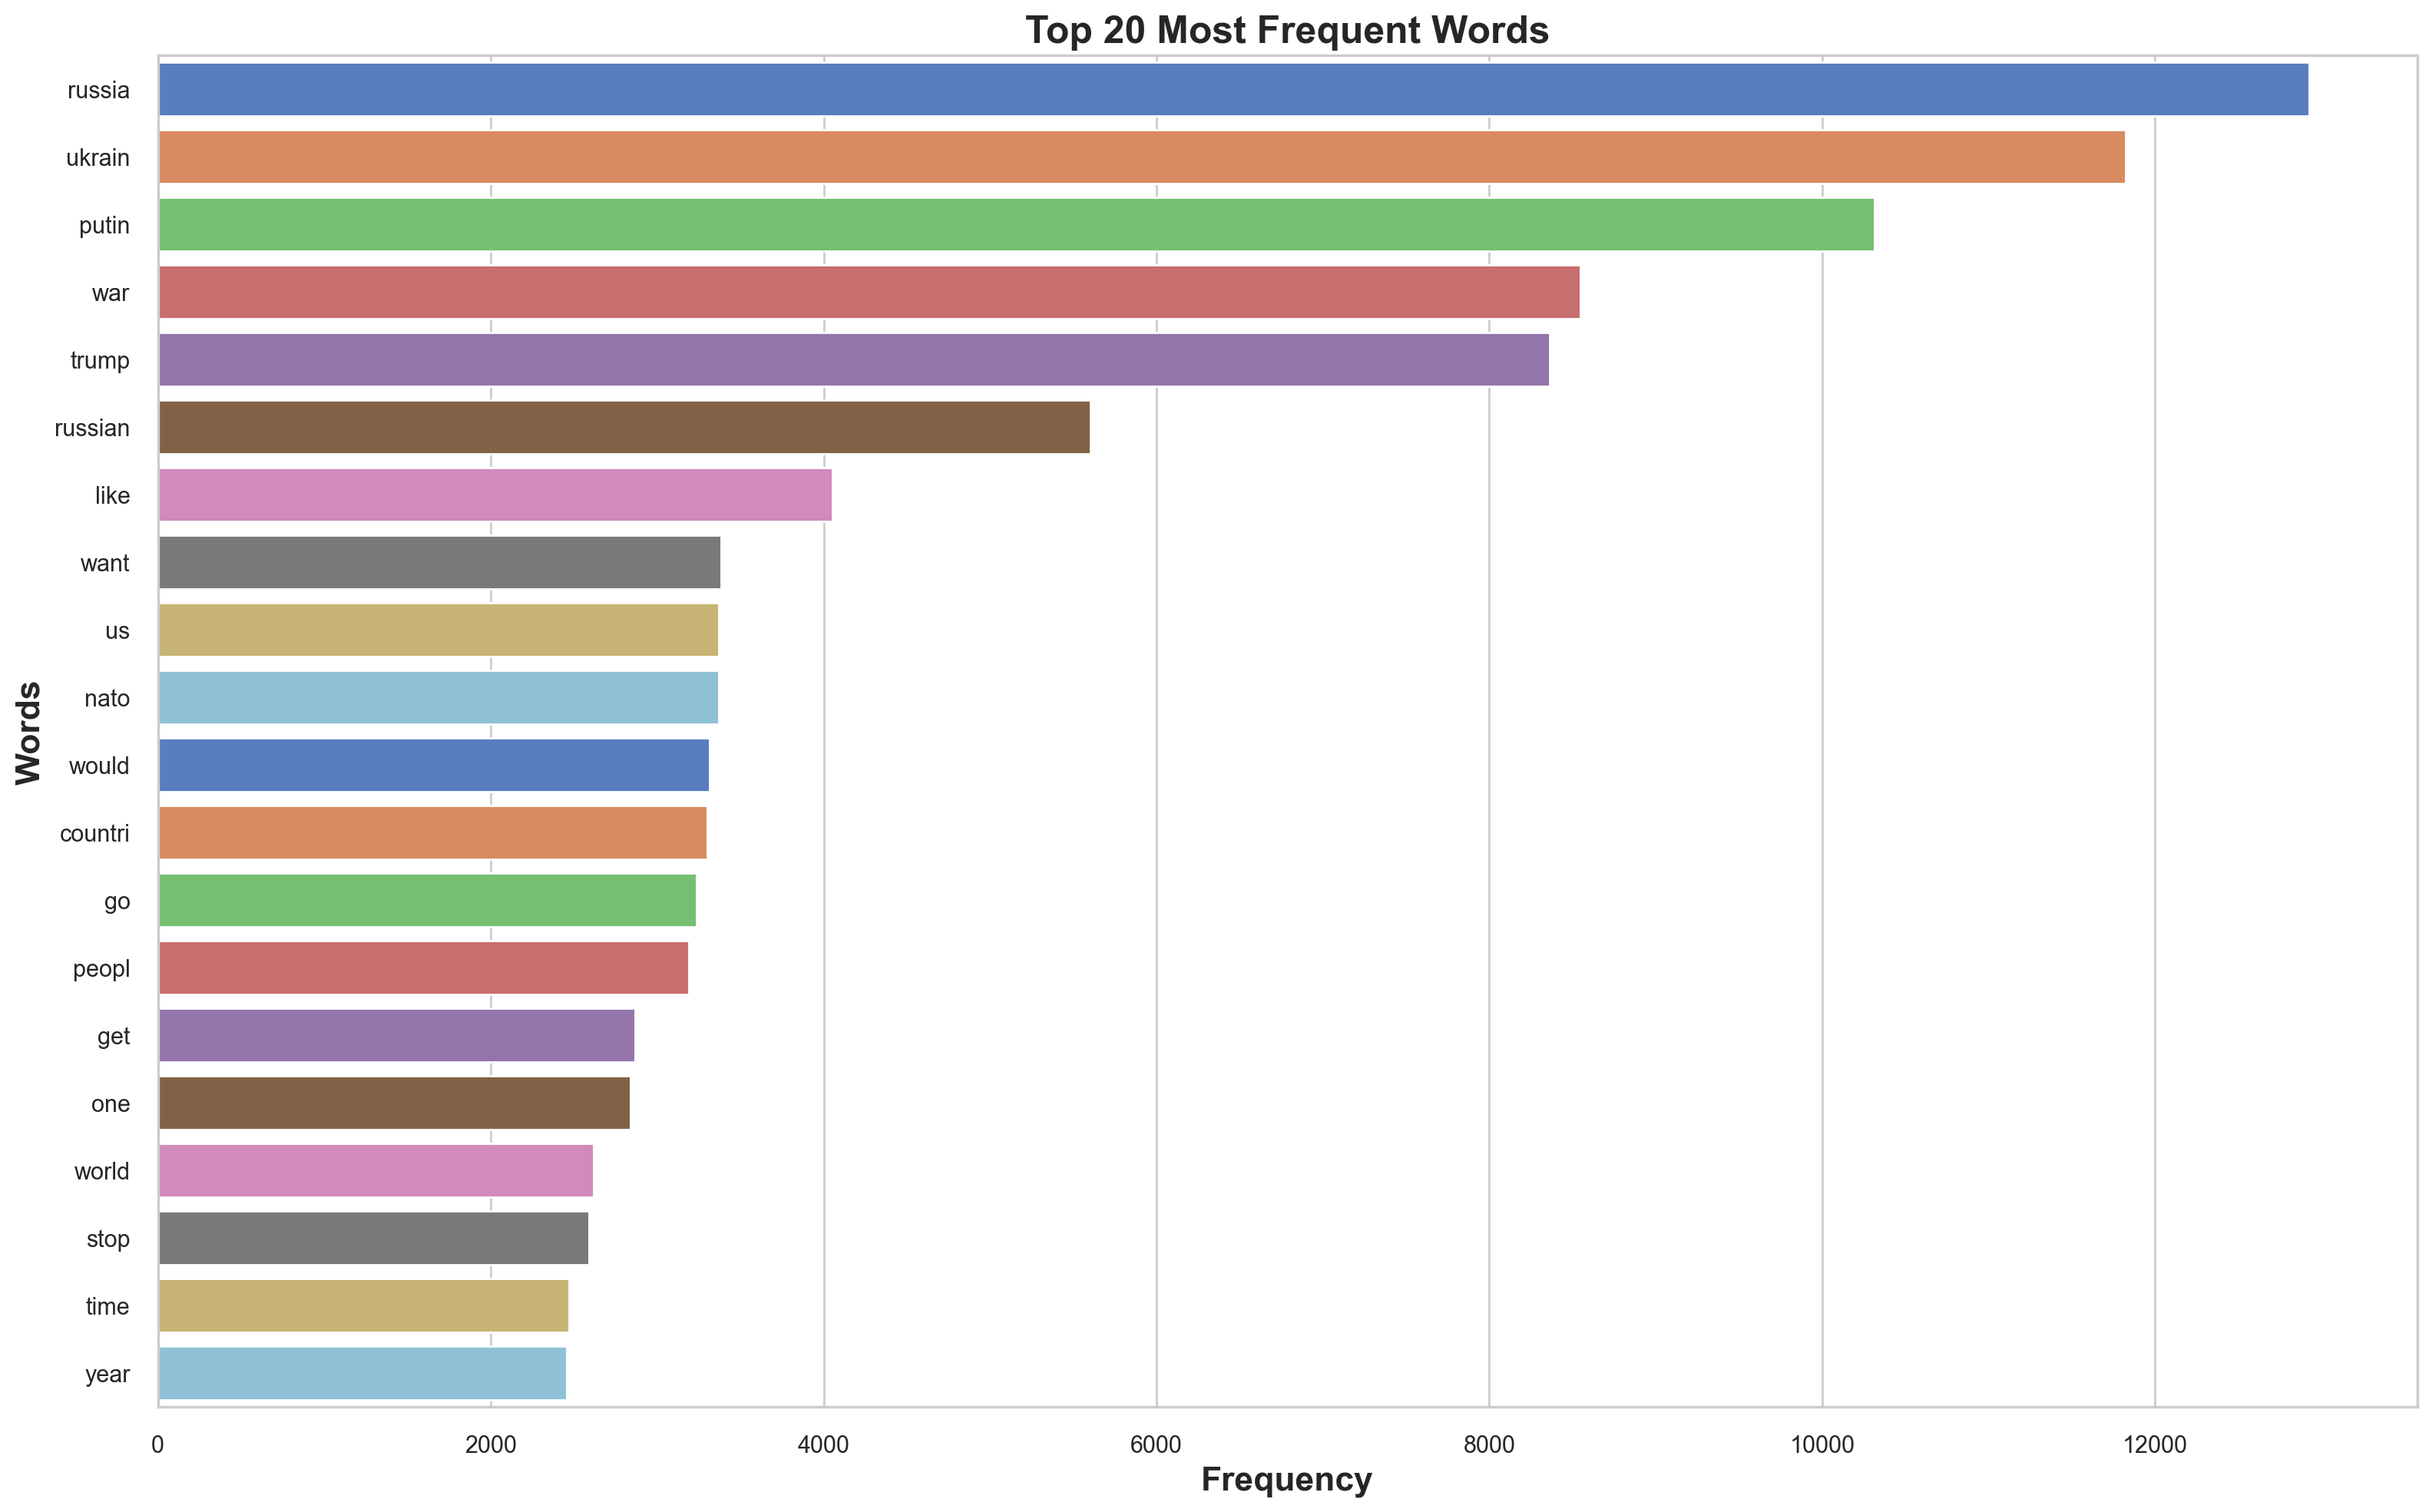

In [16]:
# Plot most common words: Top 20
top_words = word_freq.most_common(20)
words, counts = zip(*top_words)
sns.barplot(x=counts, y=words, palette='muted', hue=words, orient='horizontal')
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel('Words')
plt.tight_layout()
plt.show()

## Sentiment Analysis (VADER)

In [17]:
# Initializing VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Applying VADER sentiment scoring
df["sentiment_score"] = df["clean_text_filtered"].apply(lambda x: sid.polarity_scores(x)["compound"])

def classify_sentiment(score):
    if score >= 0.01:    # More lenient for Positive
        return "Positive"
    elif score <= -0.01: # More lenient for Negative
        return "Negative"
    return "Neutral"

# Classifying sentiment based on the score
df["sentiment"] = df["sentiment_score"].apply(classify_sentiment)

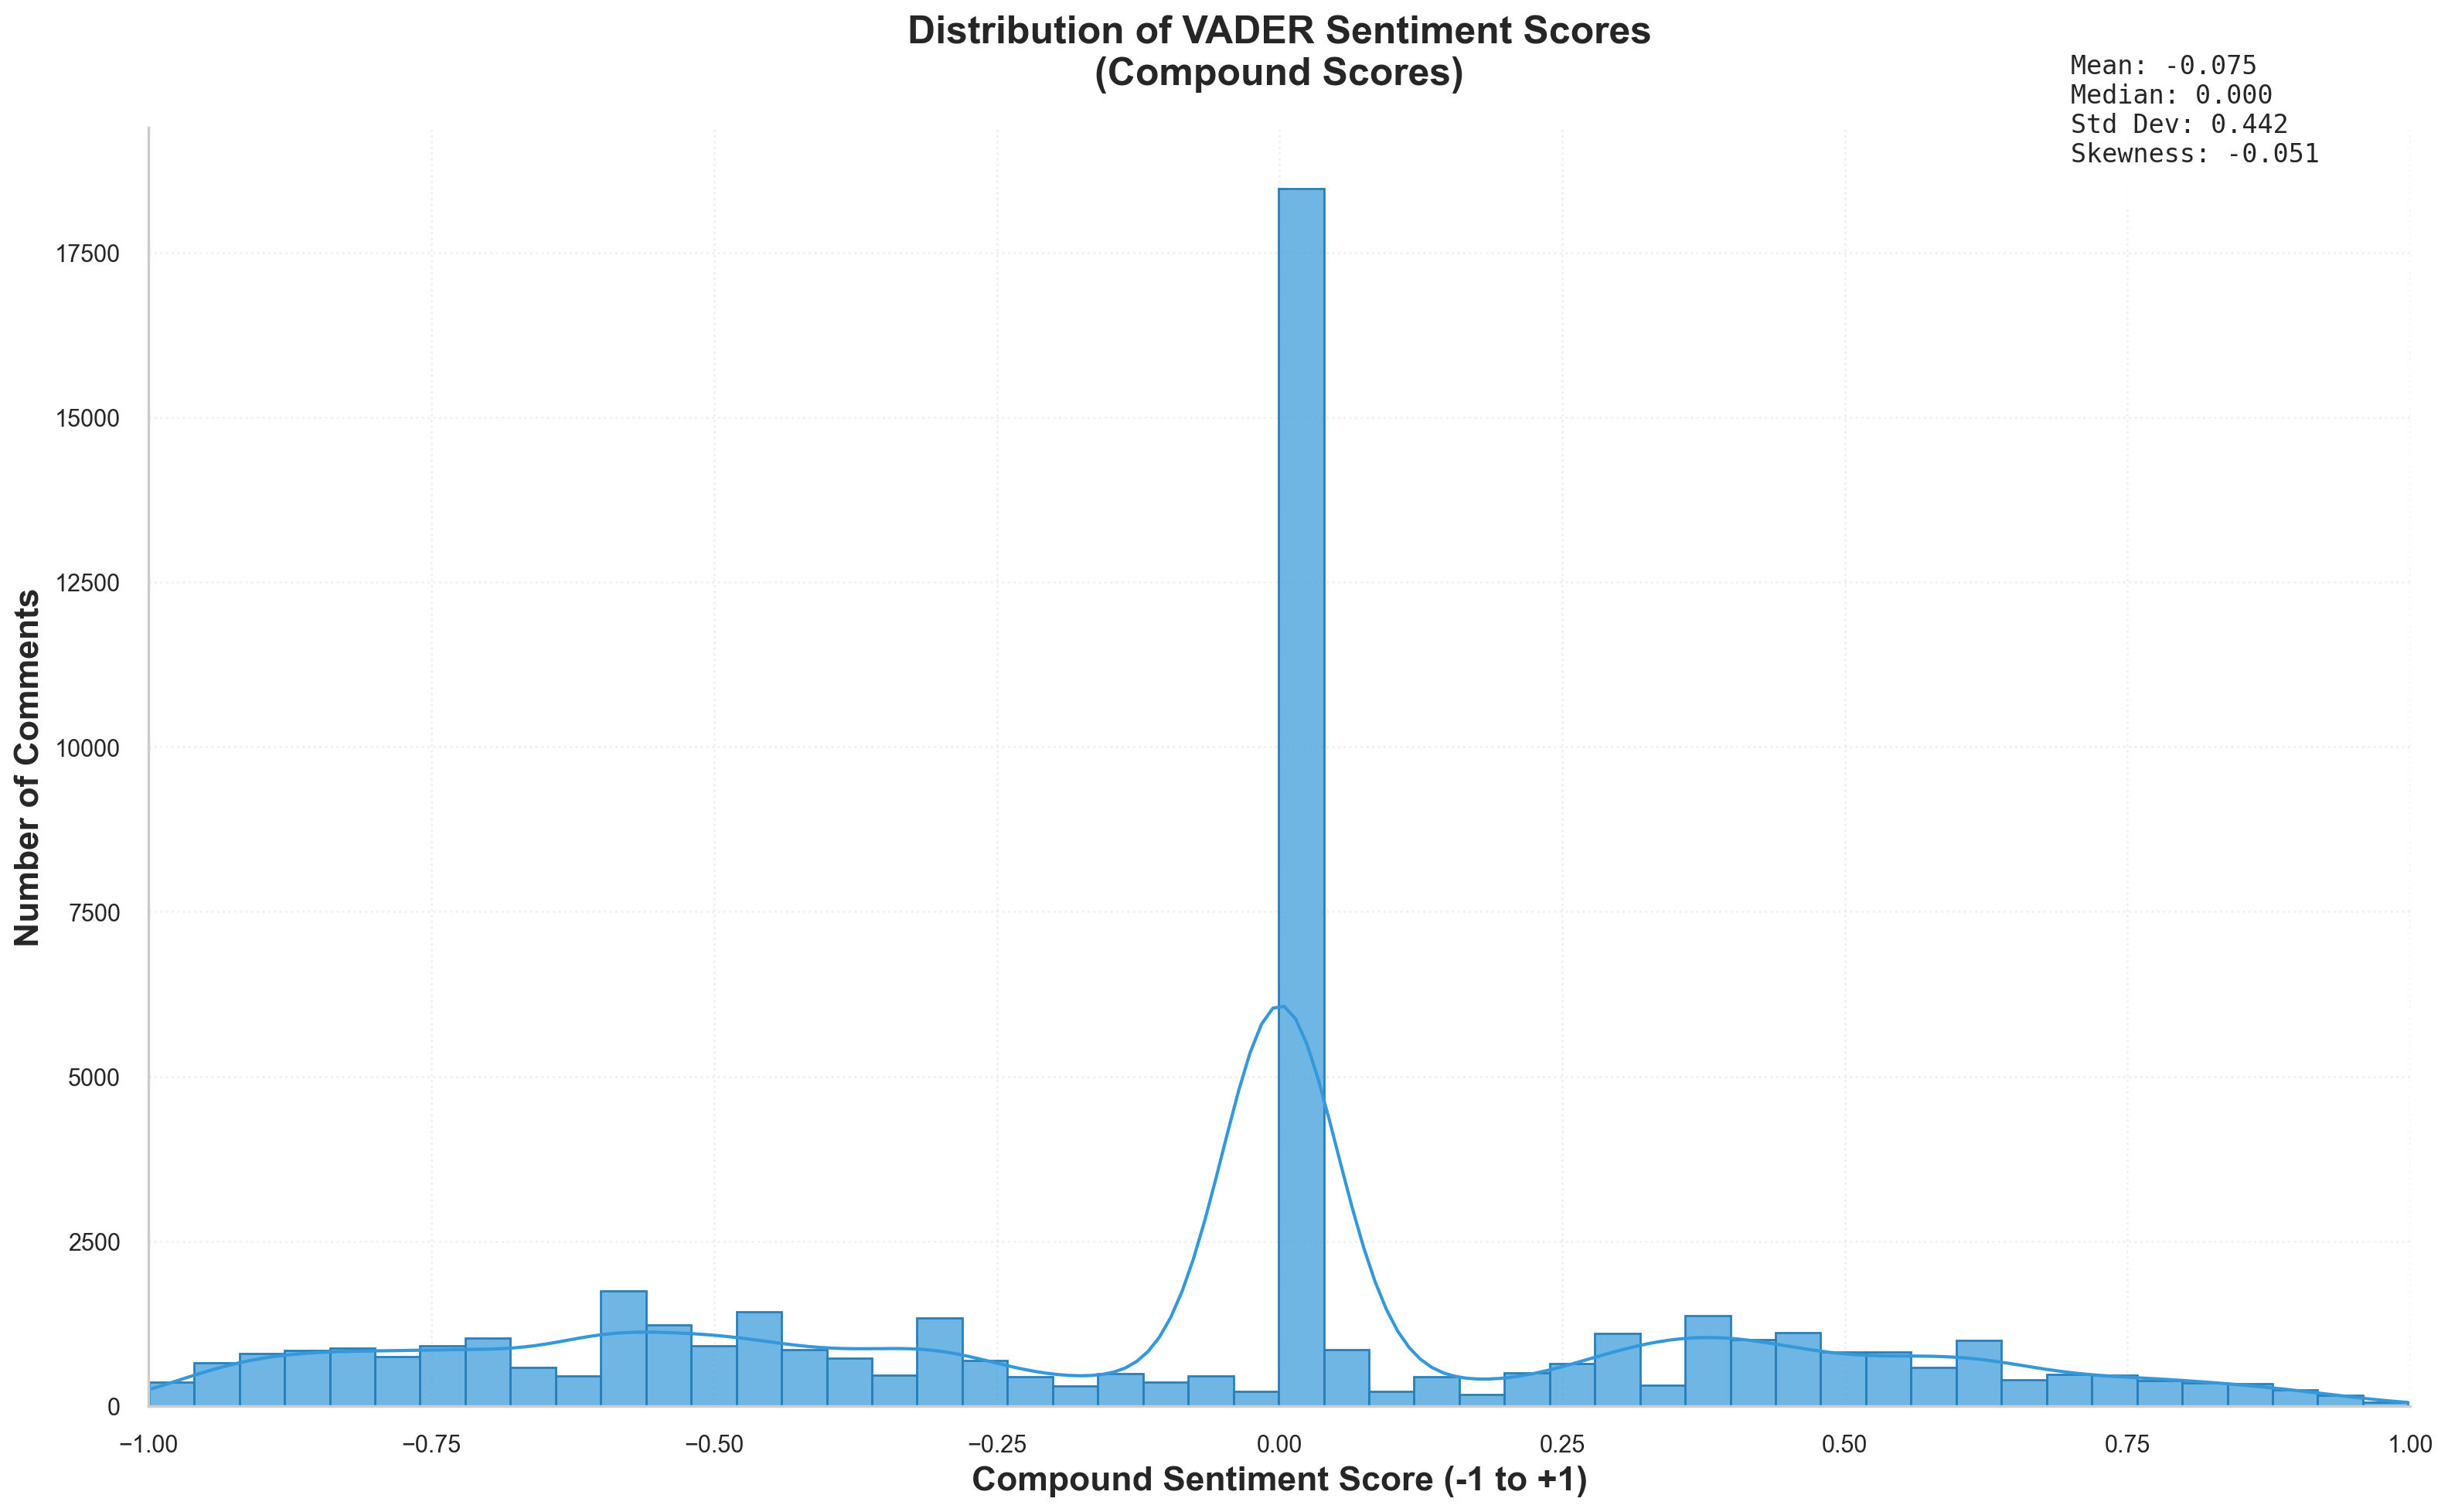

In [18]:
# Distribution of sentiment scores
ax = sns.histplot(df['sentiment_score'], 
                 bins=50, 
                 kde=True,
                 color='#3498db',
                 edgecolor='#2980b9',
                 alpha=0.7)
plt.title('Distribution of VADER Sentiment Scores\n(Compound Scores)', pad=20)
plt.xlabel('Compound Sentiment Score (-1 to +1)')
plt.ylabel('Number of Comments')
plt.xlim(-1, 1)
plt.grid(True, linestyle=':', alpha=0.3)

# Printing statistics on the plot
stats_text = f"""
Mean: {df['sentiment_score'].mean():.3f}
Median: {df['sentiment_score'].median():.3f}
Std Dev: {df['sentiment_score'].std():.3f}
Skewness: {df['sentiment_score'].skew():.3f}
"""
plt.text(0.85, 0.95, stats_text, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8), fontfamily='monospace')
sns.despine()
plt.tight_layout()
plt.show()

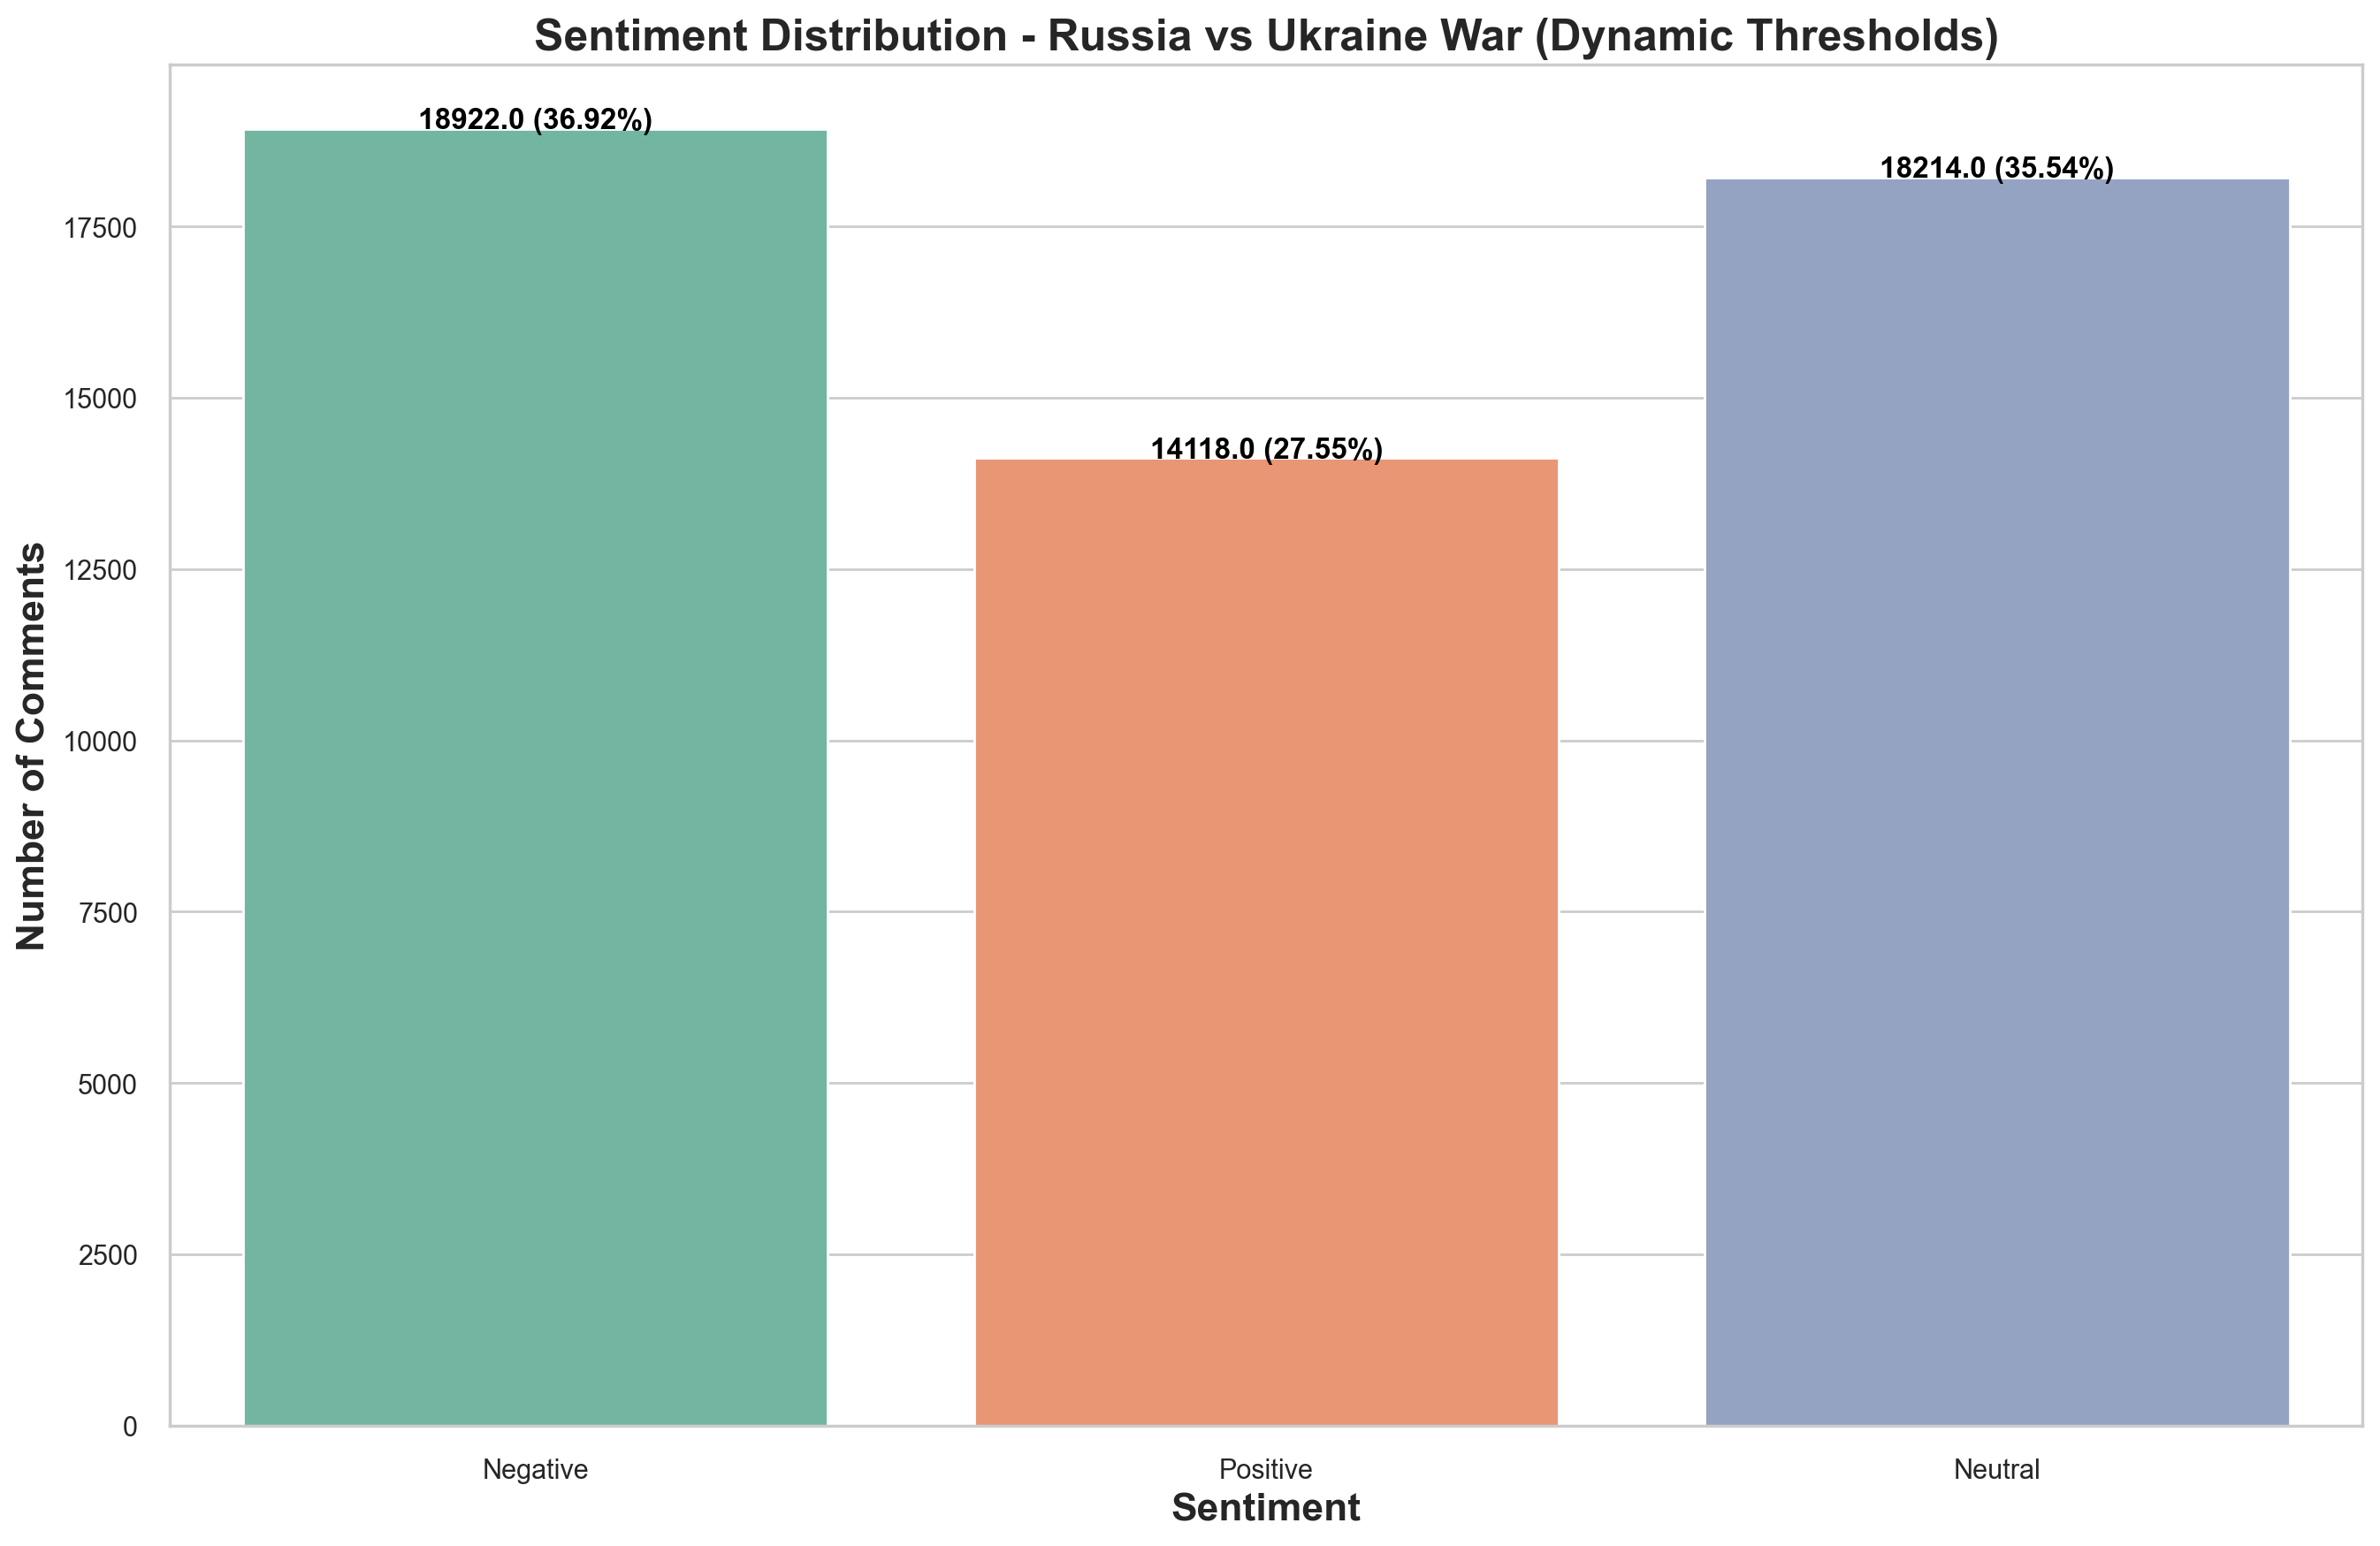

In [19]:
# Plotting Sentiment Distribution
ax = sns.countplot(data=df, x='sentiment', palette='Set2', hue='sentiment')
plt.title("Sentiment Distribution - Russia vs Ukraine War (Dynamic Thresholds)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2, height + 10, f'{height} ({percentage:.2f}%)',
            ha='center', fontweight='bold', color='black')
plt.show()

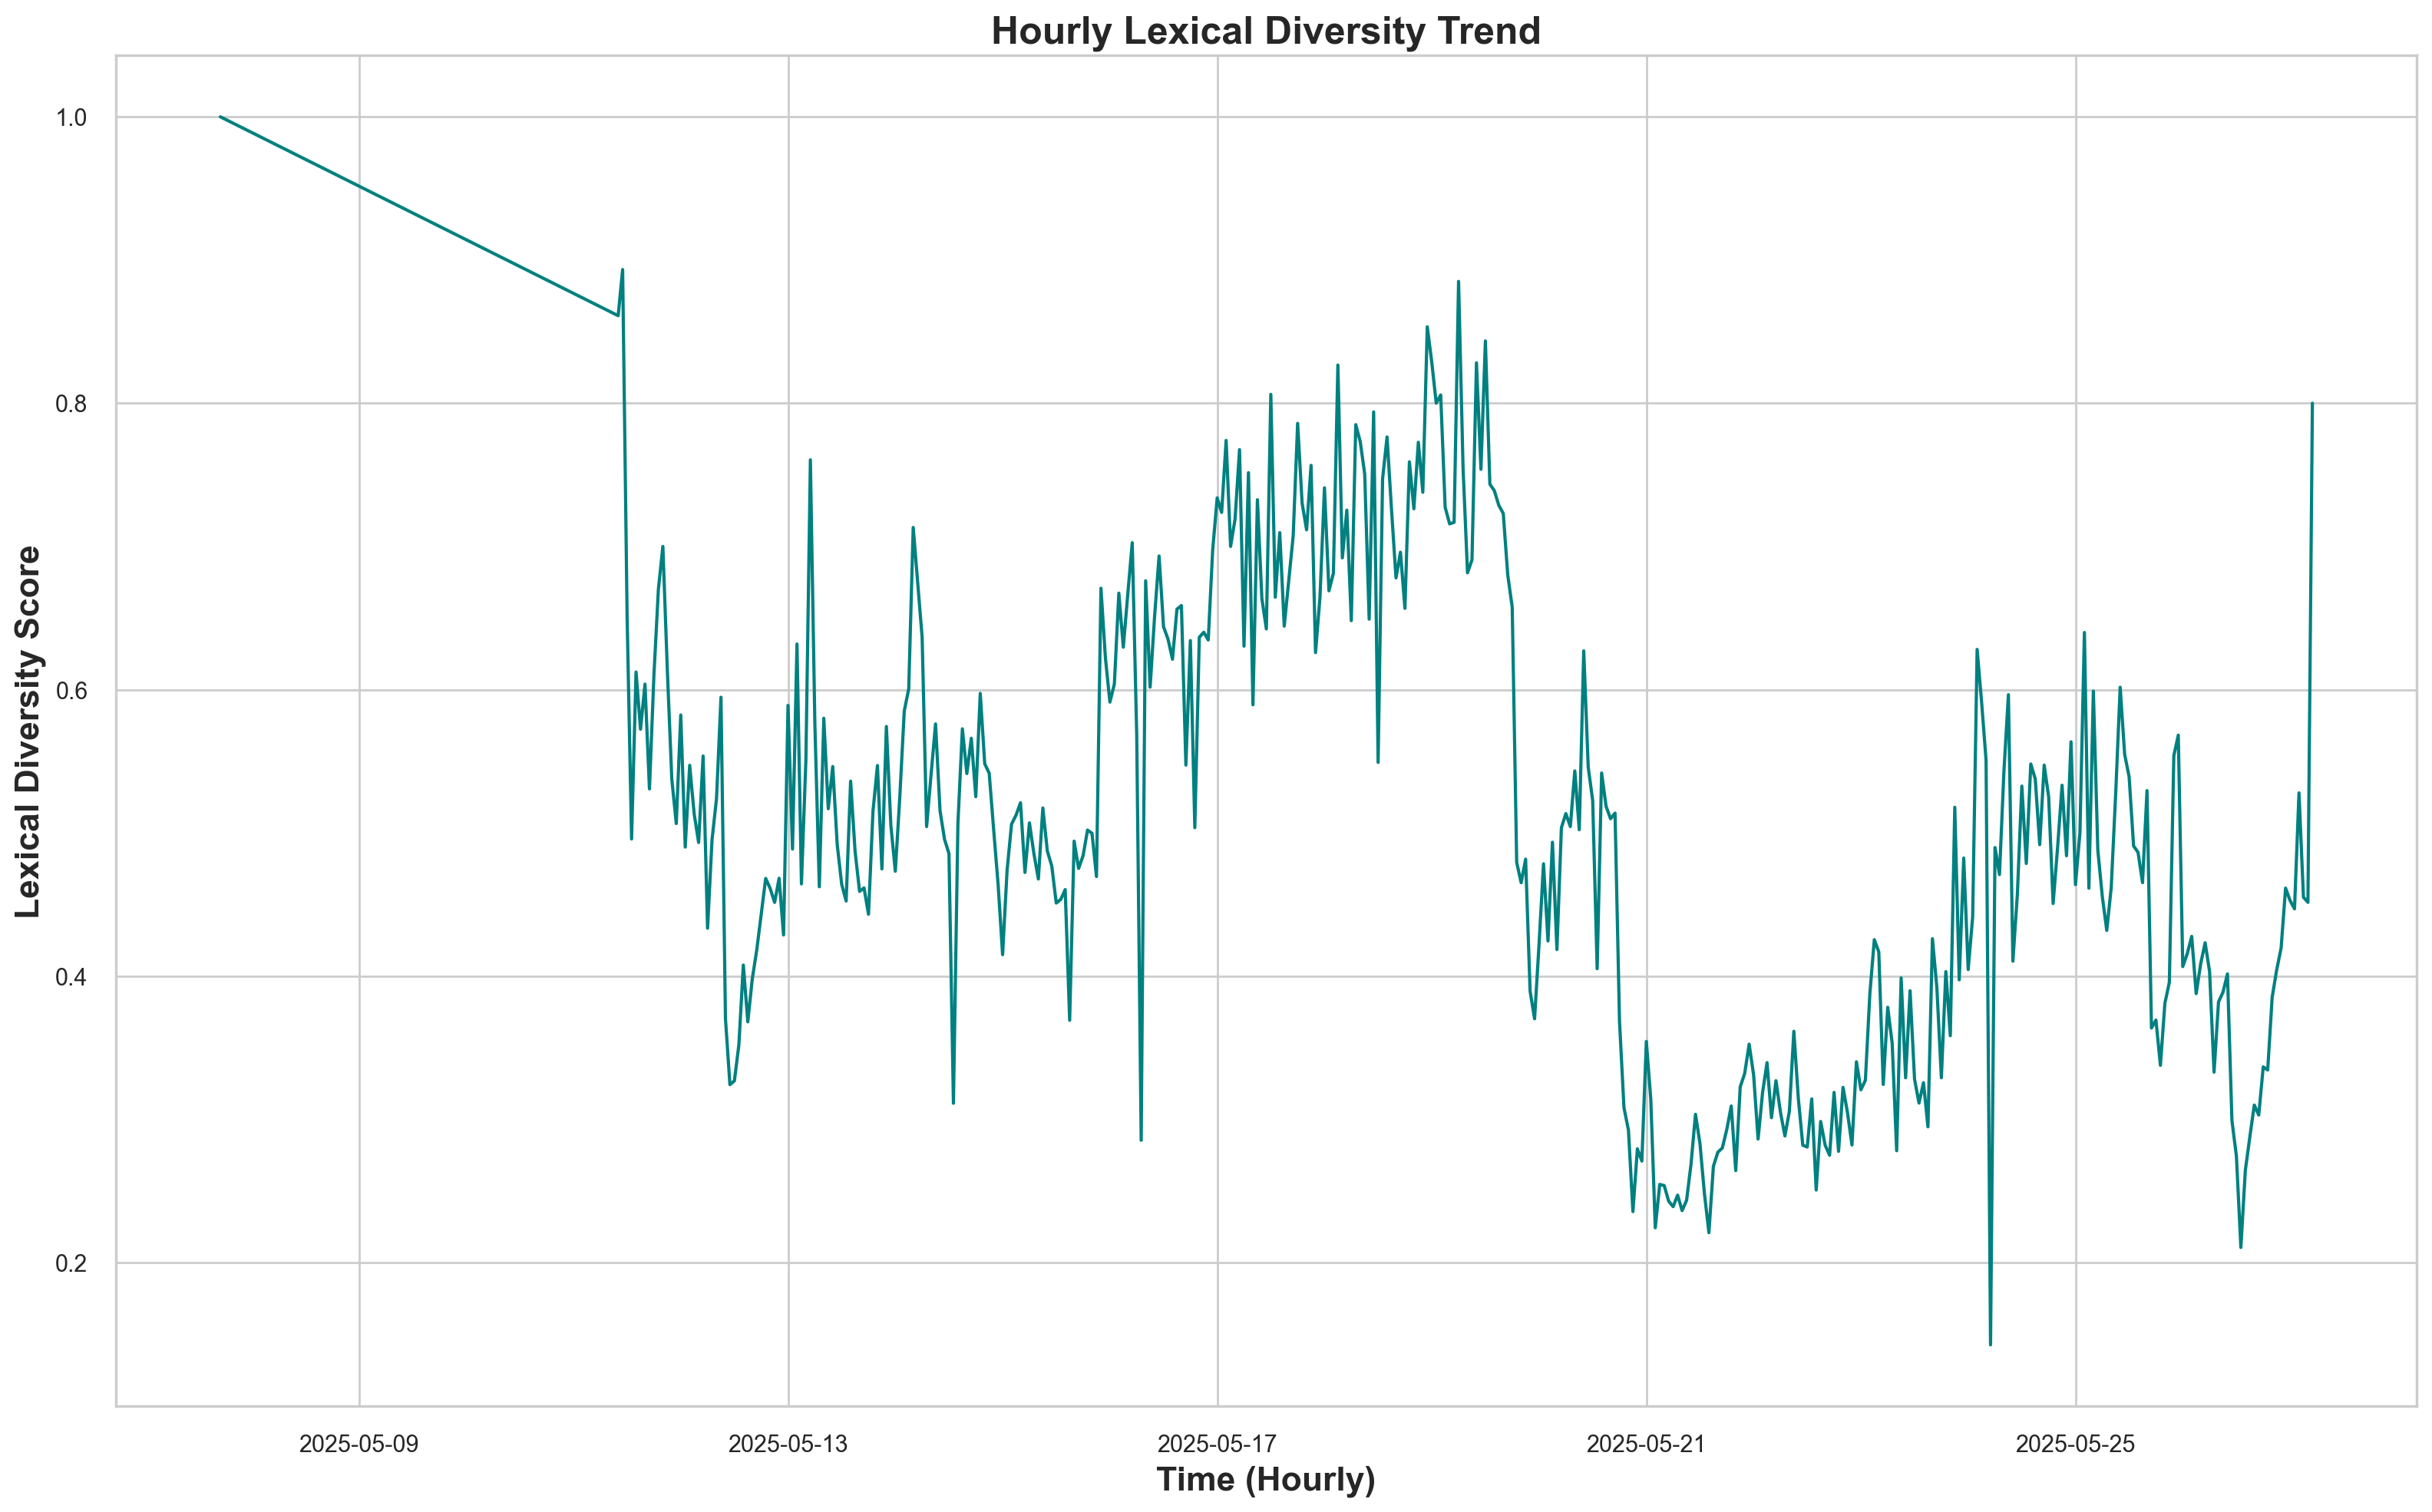

In [20]:
# Convert videoPublishedAt to datetime
df['date'] = pd.to_datetime(df['publishedAt'], errors='coerce')

# Grouping by hour instead of date
hourly_diversity = df.groupby(df['date'].dt.floor('H'))['clean_text_filtered'] \
    .apply(lambda x: len(set(" ".join(x).split())) / len(" ".join(x).split()) if len(" ".join(x).split()) > 0 else 0)

# Plotting the hourly trend
plt.plot(hourly_diversity.index, hourly_diversity.values, color='teal')
plt.title('Hourly Lexical Diversity Trend')
plt.xlabel('Time (Hourly)')
plt.ylabel('Lexical Diversity Score')
plt.tight_layout()
plt.show()

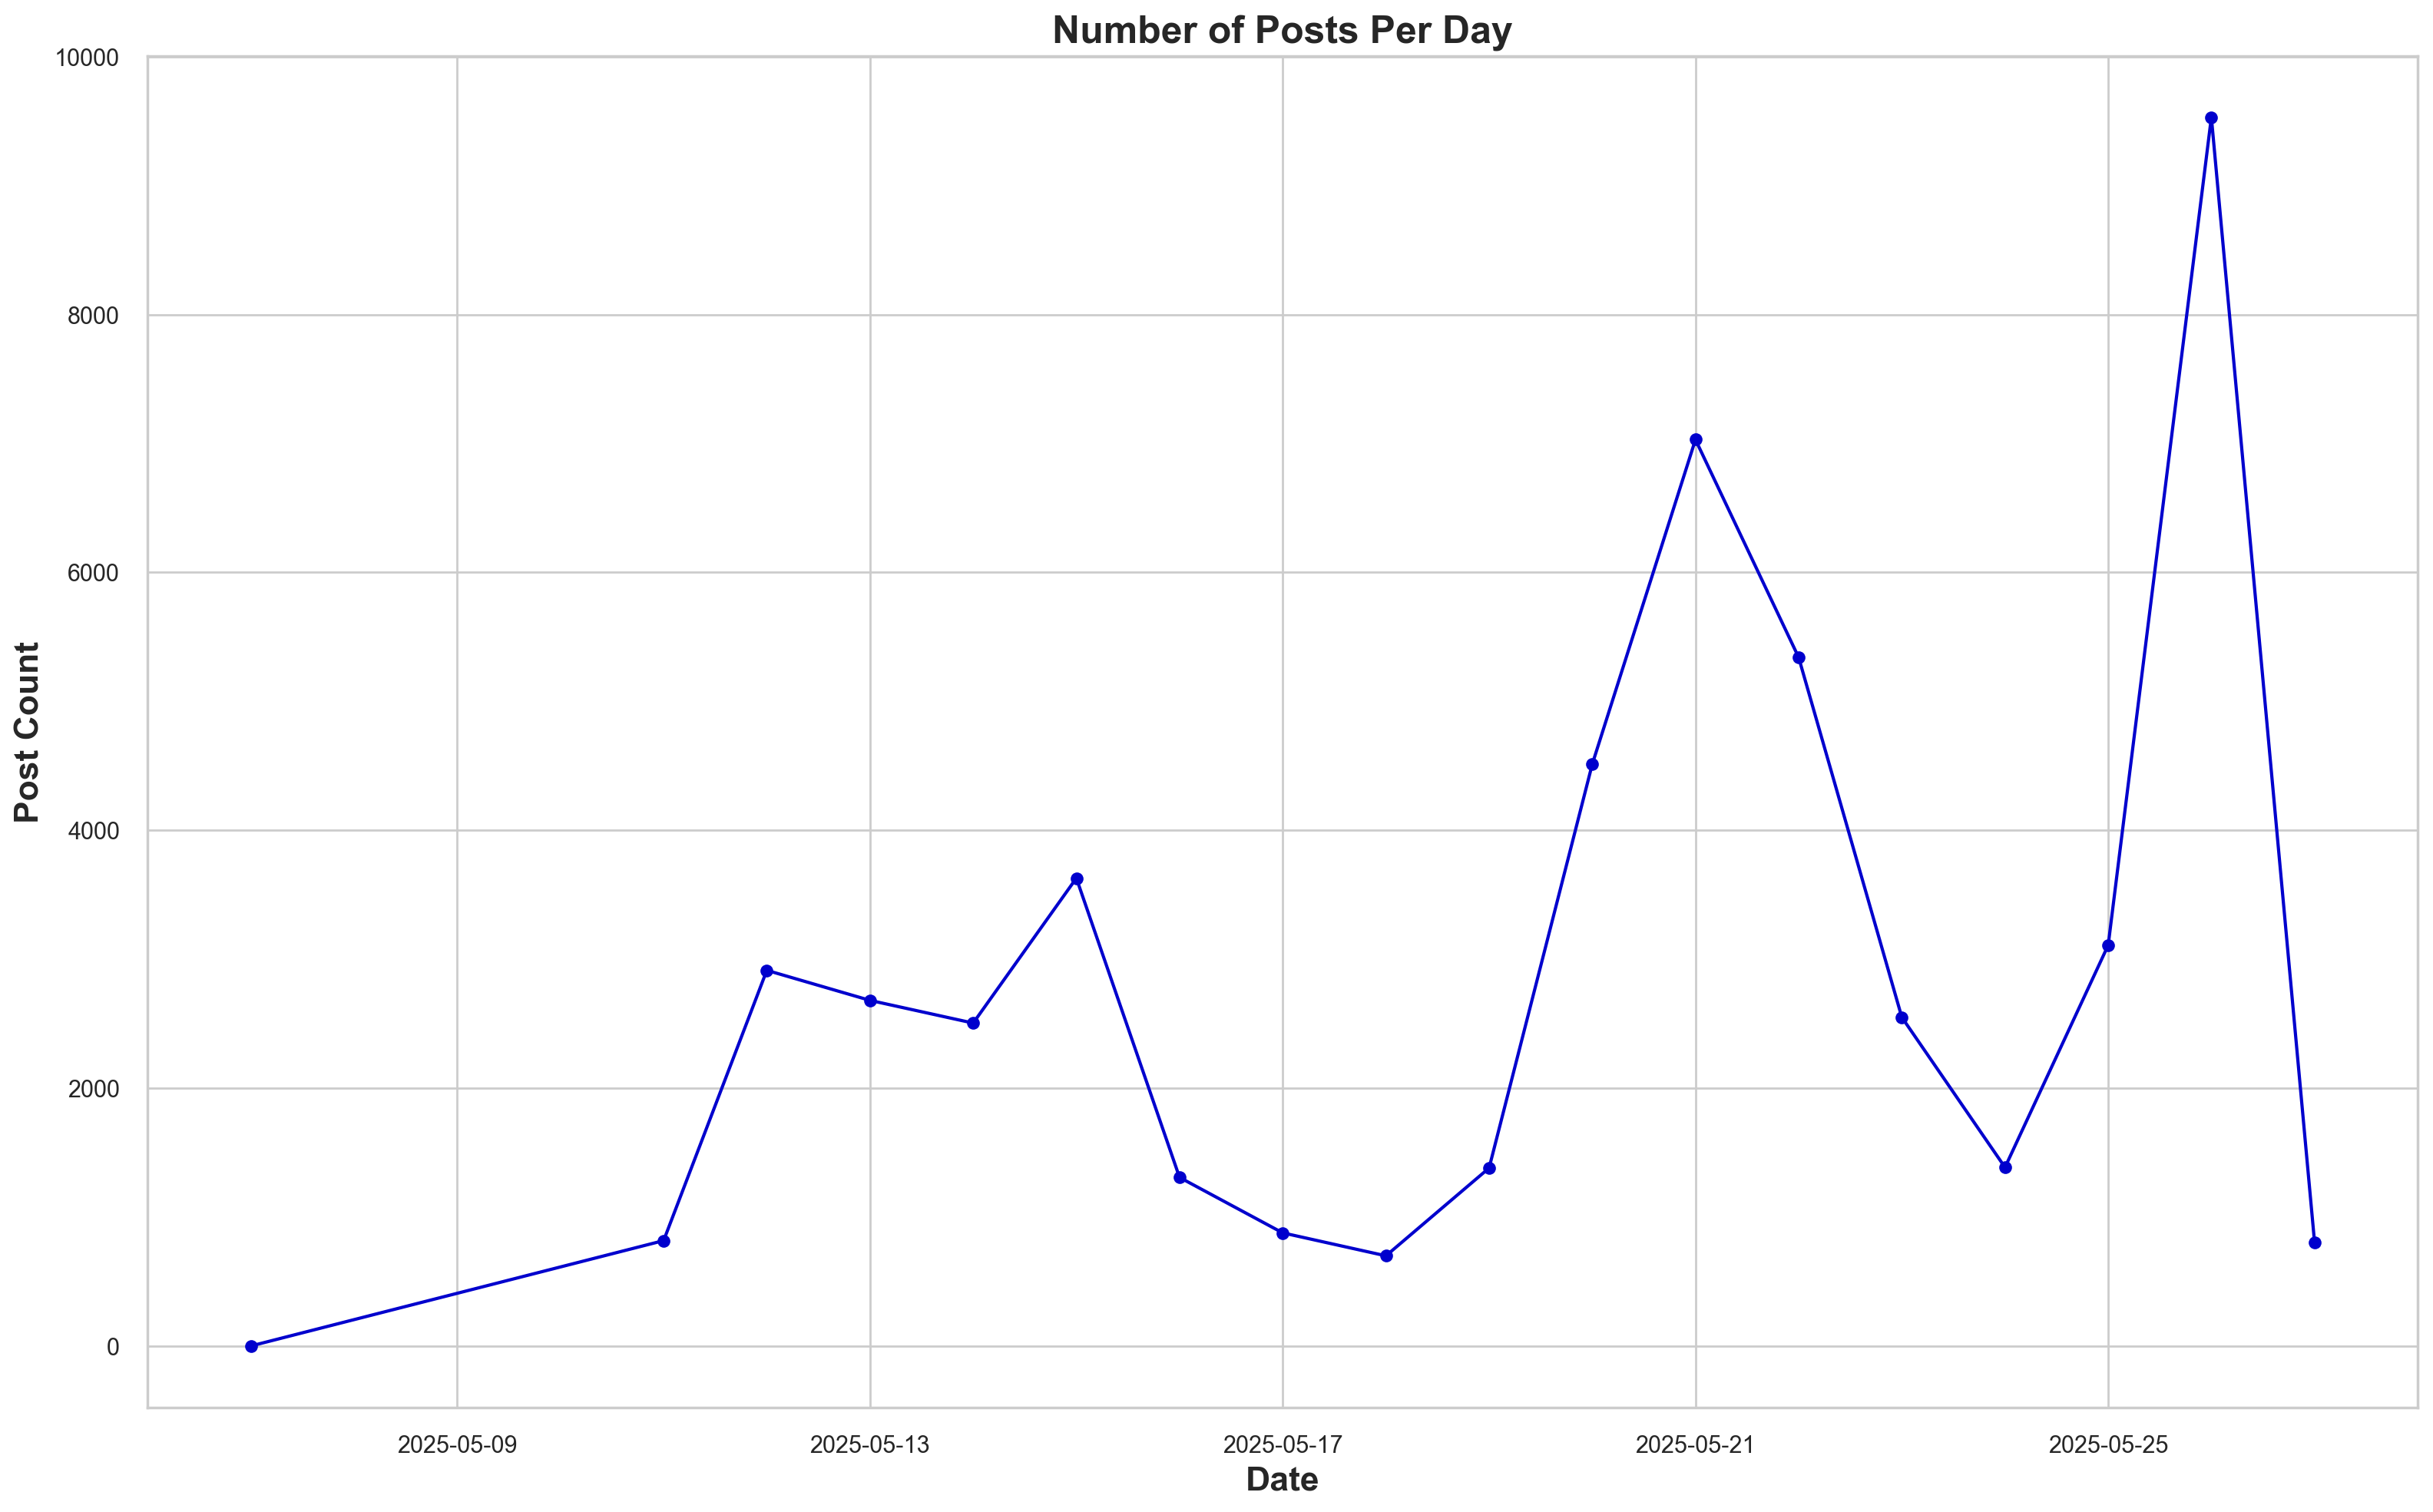

In [21]:
# Group by date (day)
daily_post_counts = df.groupby(df['date'].dt.date).size()

# Plotting the daily post counts
plt.plot(daily_post_counts.index, daily_post_counts.values, marker='o', color='mediumblue')
plt.title('Number of Posts Per Day')
plt.xlabel('Date')
plt.ylabel('Post Count')
plt.tight_layout()
plt.show()

## LDA Topic Modeling

In [22]:
# Initilizing the corpus for LDA
corpus = df["clean_text_filtered"].tolist()

# Parameters for LDA and Vectorizers
min_df = 5
max_df = 0.95           
max_iter = 25
n_top_words = 10
max_features = 4000
seed_value = 999

# Function to print topics
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Function to display word clouds for each topic
def display_word_cloud(model, feature_names, sup_title):
    normalised_components = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    topic_num = len(model.components_)
    col_num = 3
    row_num = int(math.ceil(topic_num / col_num))
    for topic_id, l_topic_dist in enumerate(normalised_components):
        l_word_prob = {feature_names[i]: _word_prob for i, _word_prob in enumerate(l_topic_dist)}
        wordcloud = WordCloud(background_color='black').generate_from_frequencies(l_word_prob)
        plt.subplot(row_num, col_num, topic_id + 1)
        plt.suptitle(sup_title, fontsize=20, fontweight='bold')
        plt.title(f'Topic {topic_id + 1}')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

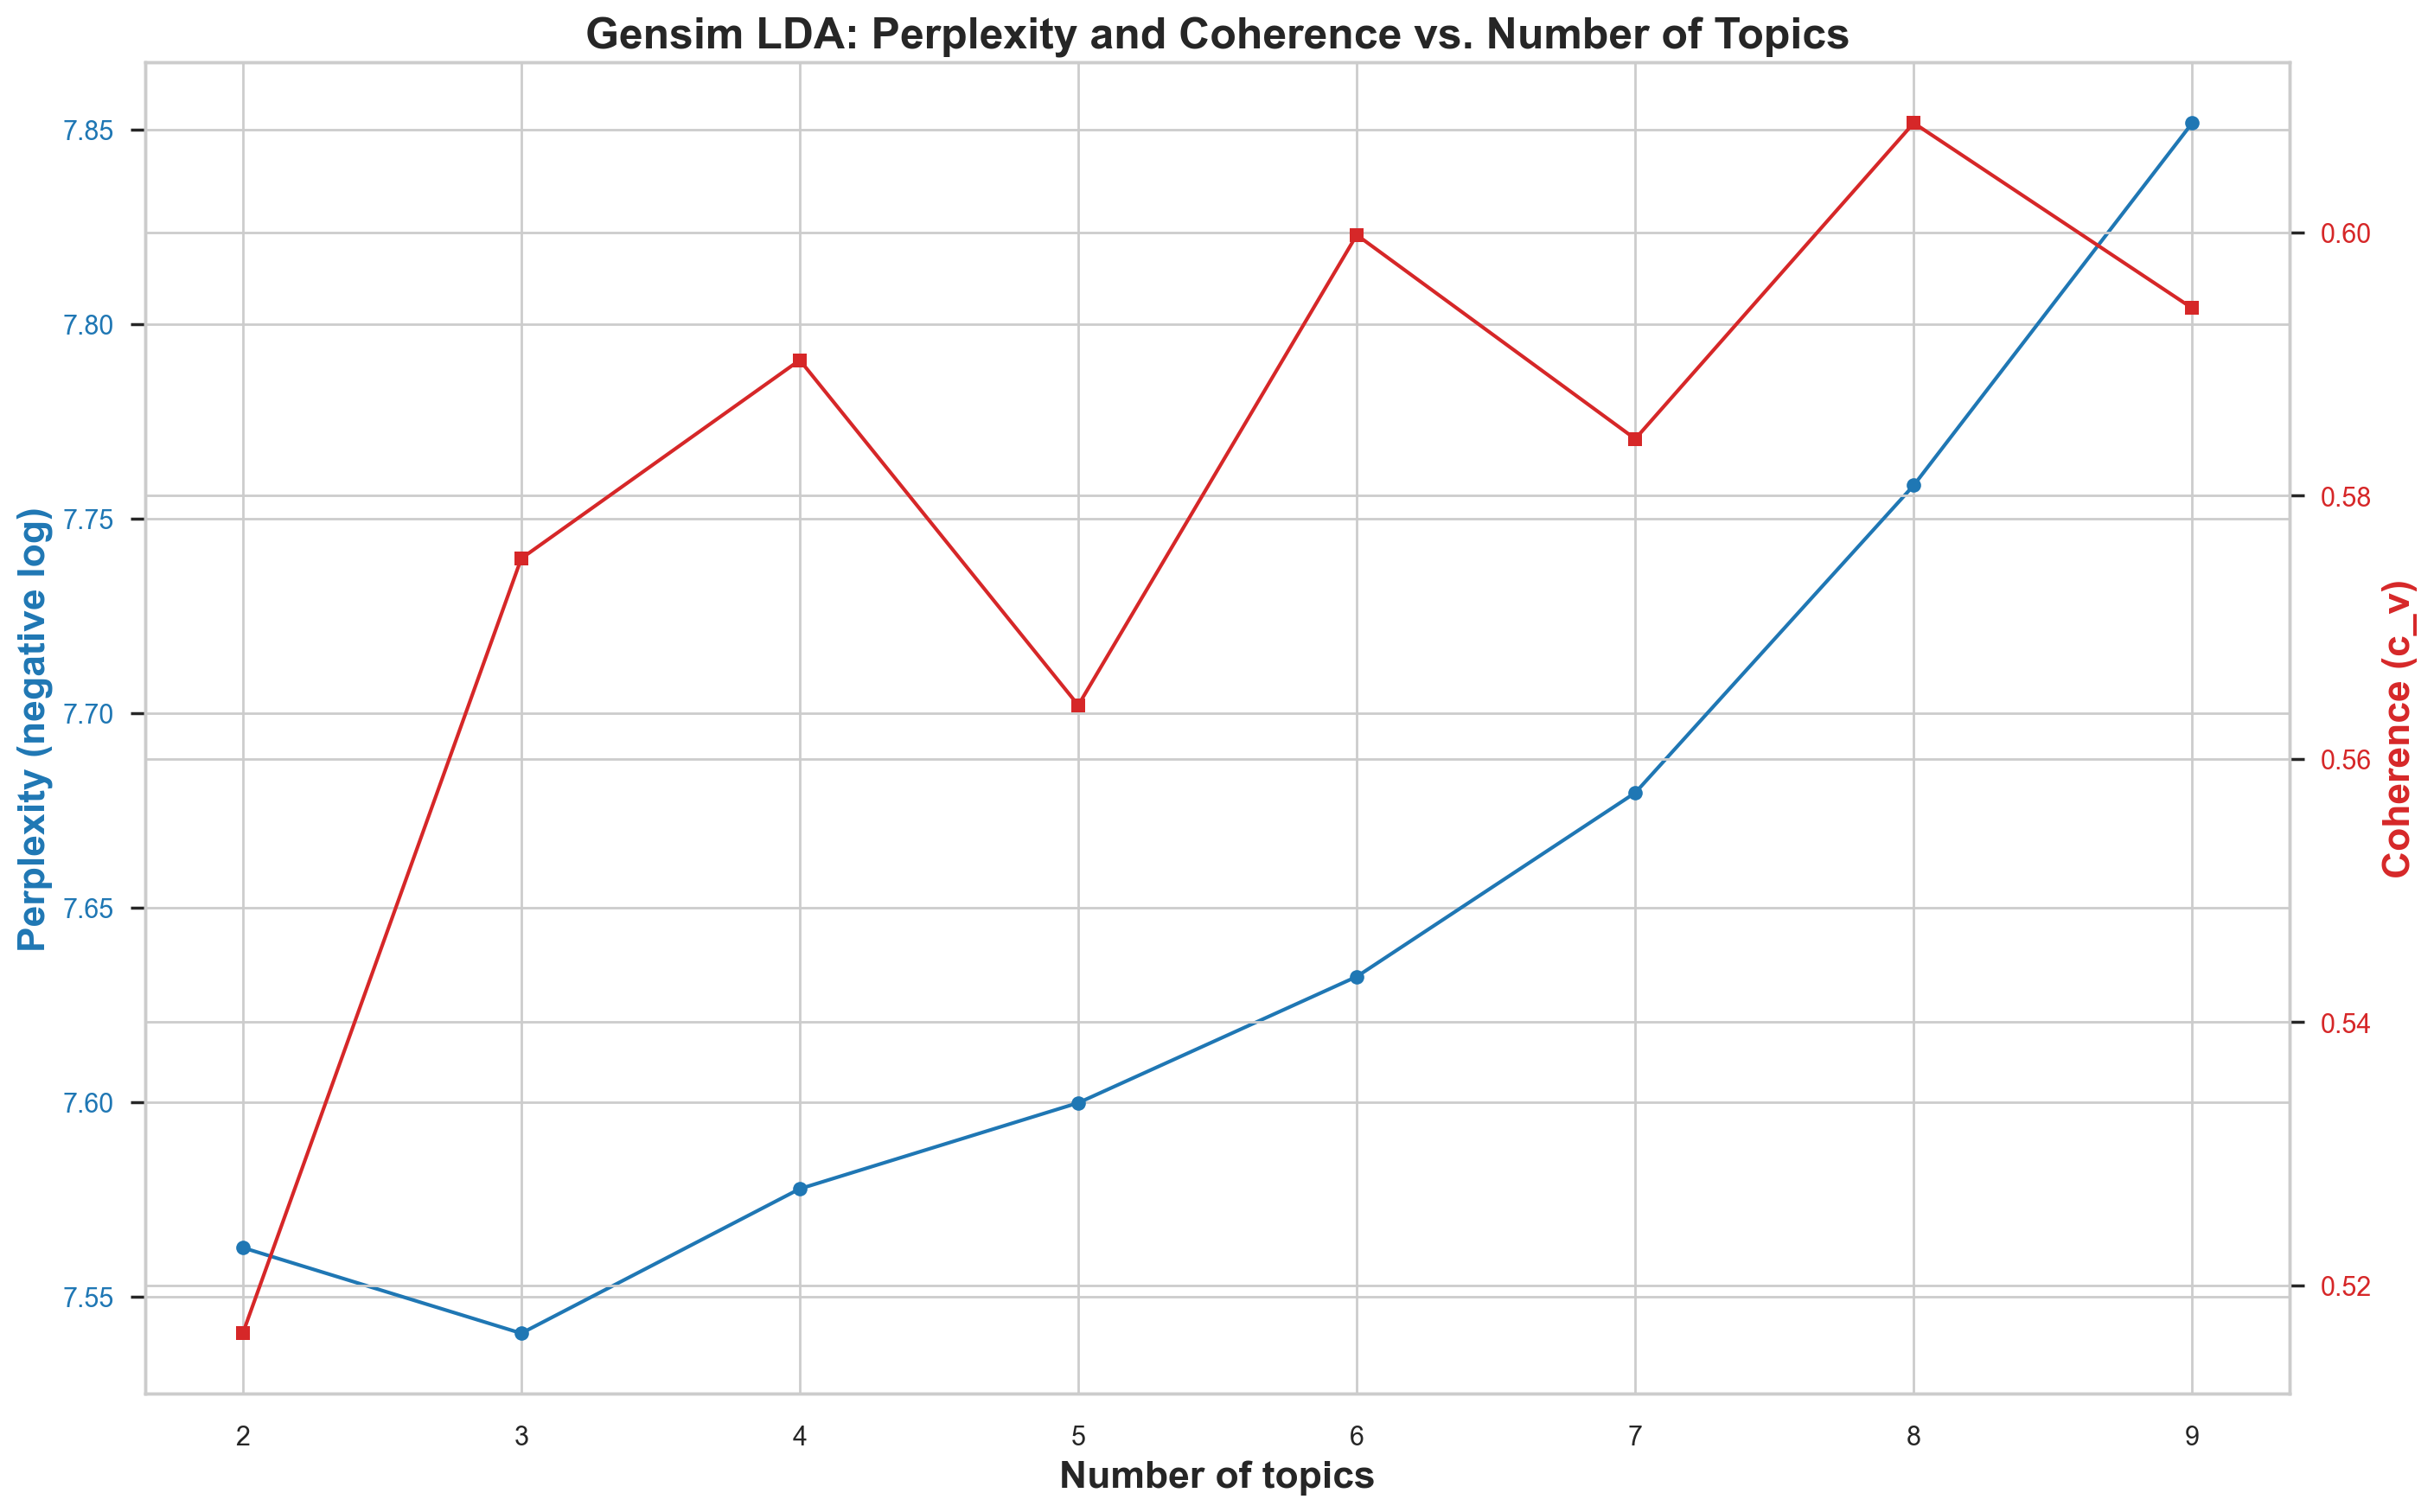

In [23]:
# Create a CountVectorizer to get the vocabulary
count_vec = CountVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words='english',
    lowercase=True,
    max_features=max_features
)
X = count_vec.fit_transform(corpus)
feature_names = count_vec.get_feature_names_out()

# Prepare data for Gensim
texts = [doc.split() for doc in corpus]  # tokenized texts
dictionary = Dictionary(texts)
gensim_corpus = [dictionary.doc2bow(text) for text in texts]

# Sweep over number of topics
topic_range = range(2, 10)
perplexities = []
coherence_scores = []

for k in topic_range:
    # Train LDA model using Gensim
    lda_model = LdaModel(
        corpus=gensim_corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=seed_value,
        iterations=max_iter,
        passes=10,               
        eval_every=None
    )

    # Gensim's bound = - per-word likelihood = log perplexity
    perplexity = lda_model.log_perplexity(gensim_corpus)
    perplexities.append(-perplexity)  # Lower is better → we negate it for plotting

    # Extract topics for coherence
    topics = [[word for word, prob in lda_model.show_topic(topicid, topn=n_top_words)]
              for topicid in range(k)]

    # Coherence score
    cm = CoherenceModel(
        topics=topics,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_scores.append(cm.get_coherence())

# Plotting both metrics
fig, ax1 = plt.subplots()

# Plotting perplexity
color = 'tab:blue'
ax1.set_xlabel('Number of topics')
ax1.set_ylabel('Perplexity (negative log)', color=color)
ax1.plot(topic_range, perplexities, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Plotting coherence on a secondary y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Coherence (c_v)', color=color)
ax2.plot(topic_range, coherence_scores, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Gensim LDA: Perplexity and Coherence vs. Number of Topics')
plt.show()

In [40]:

from sklearn.decomposition import LatentDirichletAllocation

# Number of topics to use based on the above analysis
n_topics = 6

# Initializing LDA model
base_lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=max_iter,
    random_state=seed_value,
    learning_method='online' # for large datasets
)

# Fitting CountVectorizer to the corpus
topic_fit_count_vec = count_vec.fit_transform(corpus)
feature_names_count = count_vec.get_feature_names_out()

# Fitting LDA model with CountVectorizer
lda_model_count_vec = base_lda_model
lda_model_count_vec.fit(topic_fit_count_vec)

# Displaying Topics for LDA model with CountVectorizer
print_topics(lda_model_count_vec, feature_names_count, n_top_words)


Topic #1:
putin, trump, like, man, play, thank, better, god, love, truth

Topic #2:
believ, deal, continu, media, power, care, ye, propaganda, person, watch

Topic #3:
russia, ukrain, russian, ukrainian, nato, finland, year, militari, war, attack

Topic #4:
putin, trump, war, know, talk, zelenski, presid, like, say, stop

Topic #5:
russia, ukrain, want, countri, war, eu, europ, nato, fight, start

Topic #6:
news, china, laugh, new, india, loud, channel, good, world, live


In [49]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda_model_count_vec, topic_fit_count_vec, count_vec,mds='tsne')
pyLDAvis.display(panel)


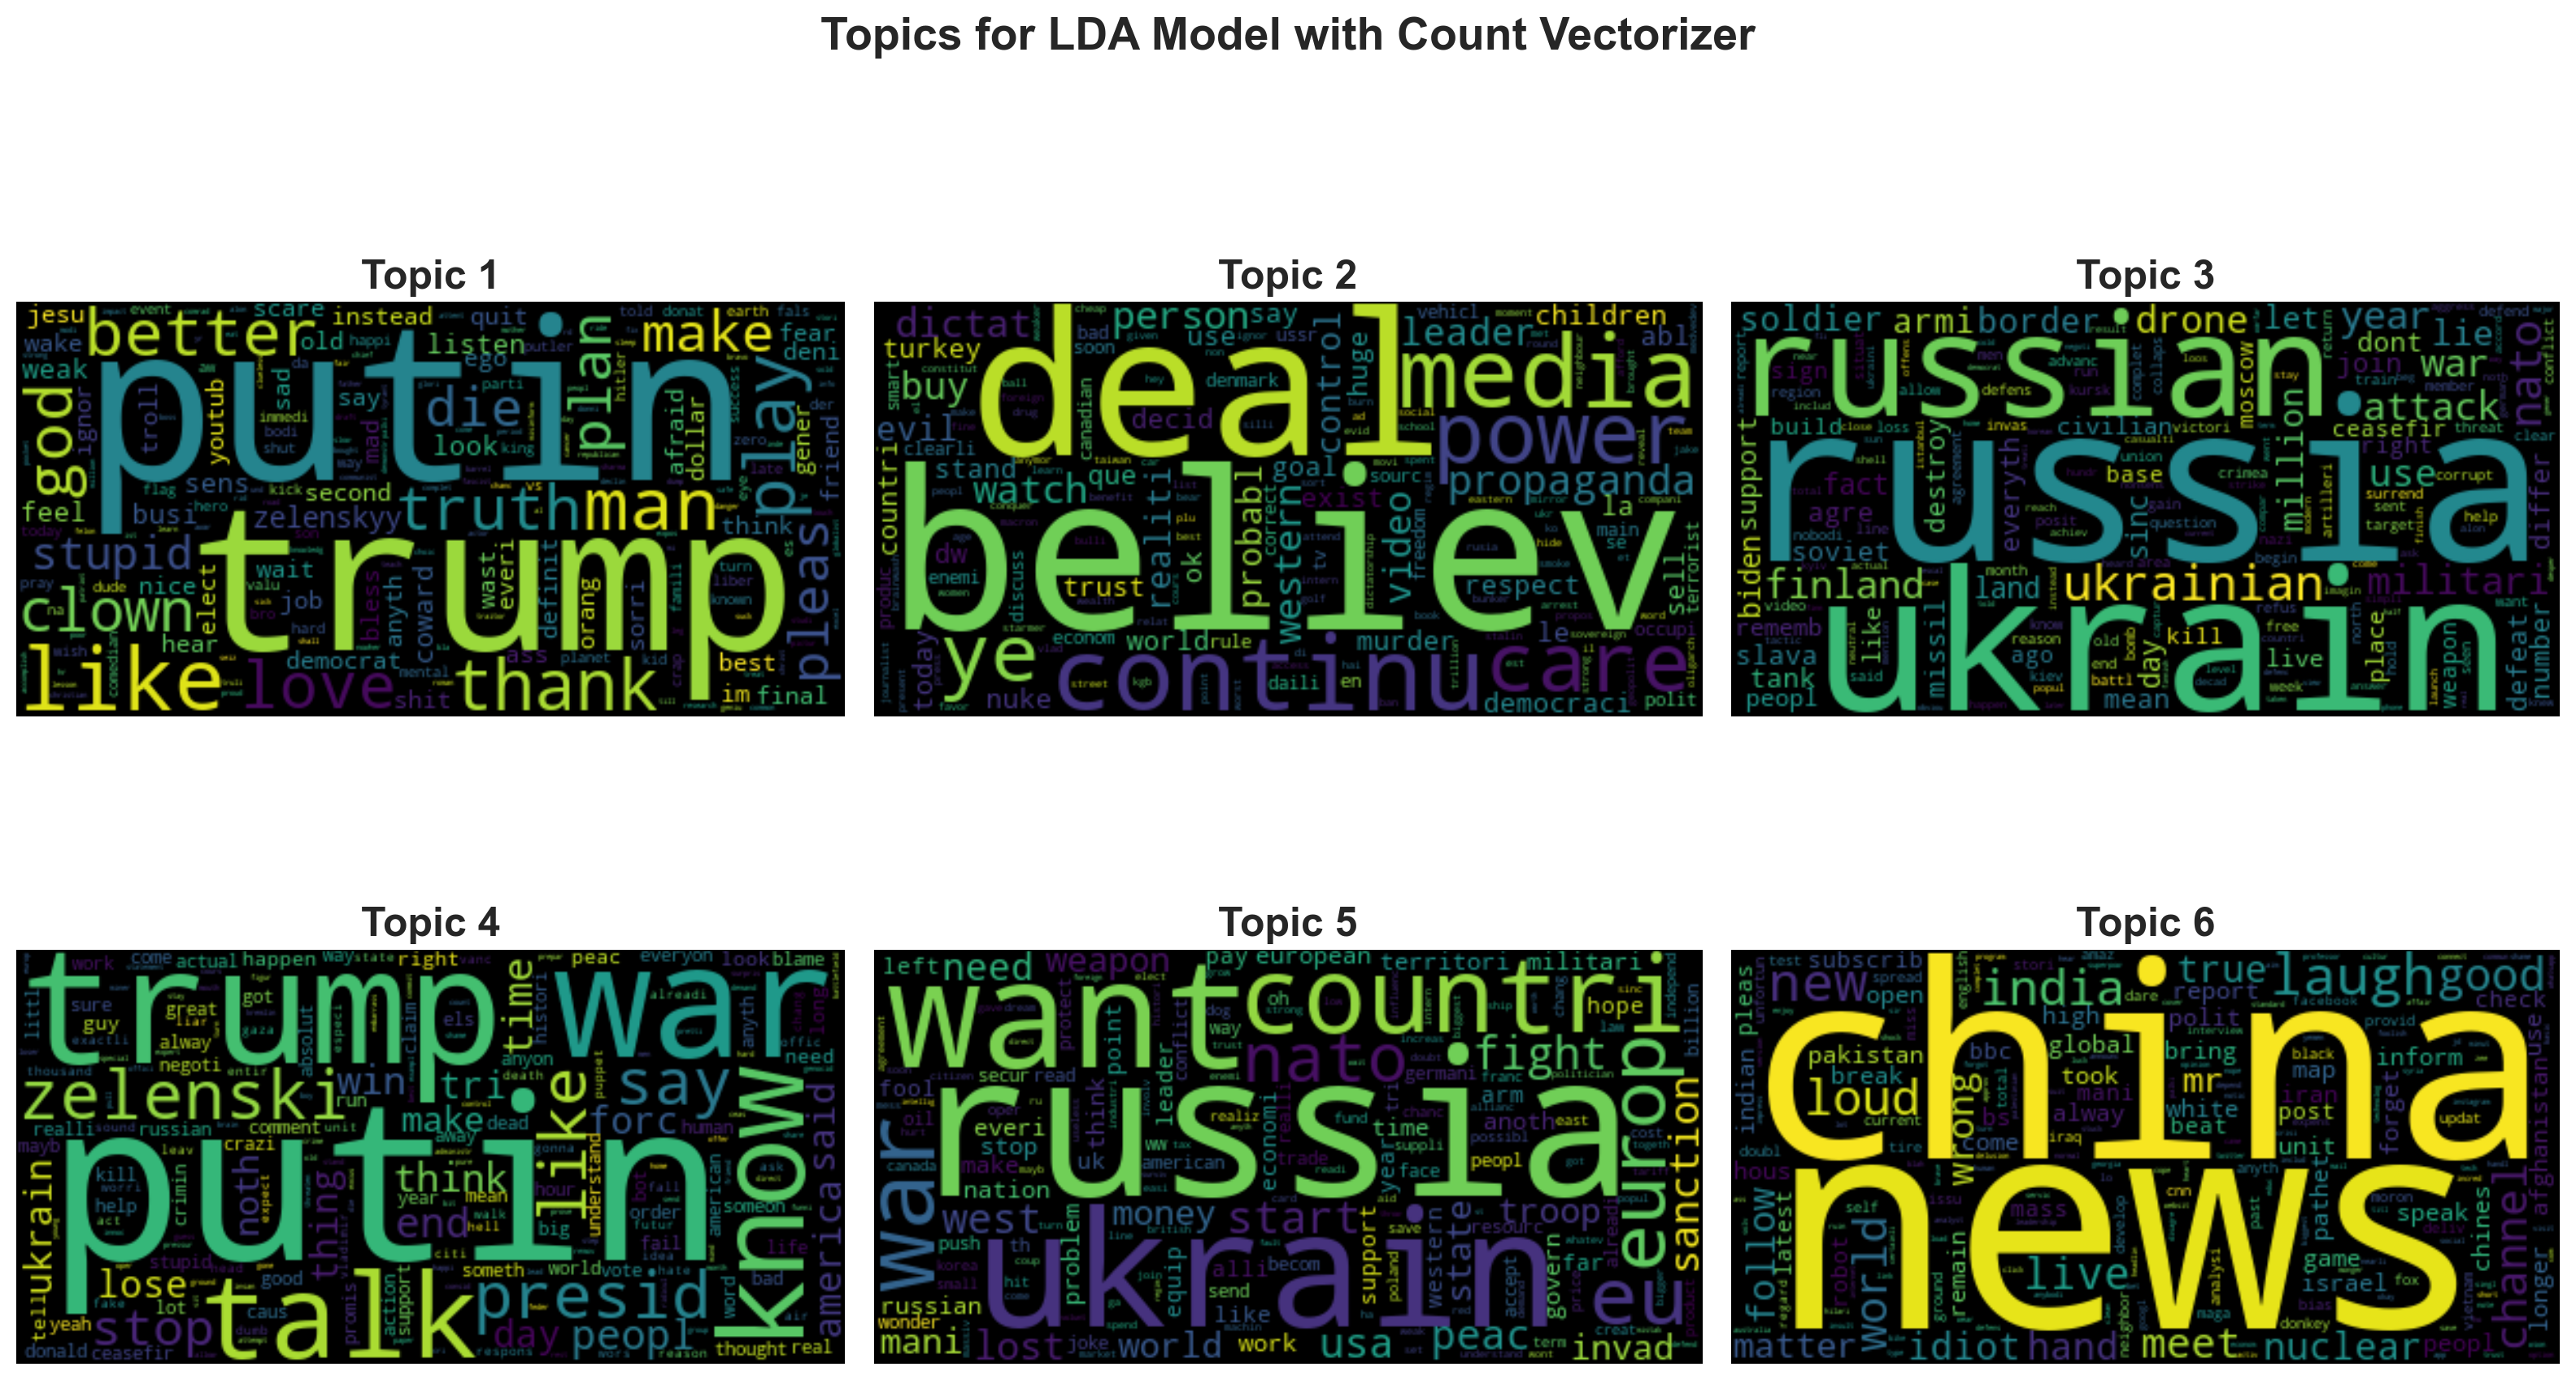

In [50]:
# Displaying topic-wise wordclouds for CountVectorizer model
display_word_cloud(lda_model_count_vec, feature_names_count, sup_title="Topics for LDA Model with Count Vectorizer")

In [51]:
df.columns

Index(['videoId', 'text', 'title', 'description', 'channelTitle',
       'videoPublishedAt', 'tags', 'viewCount', 'videoLikeCount',
       'videoCommentCount', 'type', 'commentId', 'author', 'likeCount',
       'publishedAt', 'parentId', 'authorChannelId', 'processed_tokens',
       'clean_text_filtered', 'sentiment_score', 'sentiment', 'date'],
      dtype='object')

In [52]:
df.dtypes

videoId                             object
text                                object
title                               object
description                         object
channelTitle                        object
videoPublishedAt       datetime64[ns, UTC]
tags                                object
viewCount                          float64
videoLikeCount                     float64
videoCommentCount                  float64
type                                object
commentId                           object
author                              object
likeCount                          float64
publishedAt            datetime64[ns, UTC]
parentId                            object
authorChannelId                     object
processed_tokens                    object
clean_text_filtered                 object
sentiment_score                    float64
sentiment                           object
date                   datetime64[ns, UTC]
dtype: object

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51254 entries, 0 to 51253
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   videoId              51254 non-null  object             
 1   text                 51254 non-null  object             
 2   title                51254 non-null  object             
 3   description          51254 non-null  object             
 4   channelTitle         51254 non-null  object             
 5   videoPublishedAt     175 non-null    datetime64[ns, UTC]
 6   tags                 175 non-null    object             
 7   viewCount            175 non-null    float64            
 8   videoLikeCount       174 non-null    float64            
 9   videoCommentCount    175 non-null    float64            
 10  type                 51254 non-null  object             
 11  commentId            51079 non-null  object             
 12  author            

In [54]:
df.describe()

viewCount  videoLikeCount  videoCommentCount     likeCount  \
count  1.750000e+02      174.000000          175.00000  51079.000000   
mean   1.475762e+05     2803.827586          479.60000      2.760175   
std    3.517949e+05     5780.746180          945.02162     16.025037   
min    9.940000e+02       22.000000           10.00000      0.000000   
25%    2.374500e+04      288.000000           41.00000      0.000000   
50%    5.164800e+04      773.000000          126.00000      0.000000   
75%    1.578670e+05     2906.500000          449.50000      1.000000   
max    3.978011e+06    41734.000000         6808.00000    857.000000   

       sentiment_score  
count     51254.000000  
mean         -0.075318  
std           0.441987  
min          -0.999700  
25%          -0.421500  
50%           0.000000  
75%           0.102700  
max           0.998100

In [55]:
# Count total number of comments
total_comments = df[df['type'] == 'comment'].shape[0]
print(f"Total number of comments: {total_comments}")

# Count total number of videos
total_videos = df[df['type'] == 'video'].shape[0]
print(f"Total number of videos  : {total_videos}")

# Count total number of replies
total_replies = df[df['type'] == 'reply'].shape[0]
print(f"Total number of replies : {total_replies}")

Total number of comments: 32653
Total number of videos  : 175
Total number of replies : 18426


In [56]:
# Count total number of comments per video
comments_per_video = df[df['type'] == 'comment'].groupby('videoId').size()
print(f"Total number of comments per video:")
comments_per_video

Total number of comments per video:


videoId
0YPV_aQhB2I    662
1ExuuRLWf7M     16
1T8Nlmipvkc    262
1kaC4Du67iE     27
2CGp0Gk68B8     72
              ... 
x_DyyPMaVR0    263
xlmMdpAmoy8     38
yMMizBEBNK4     56
yRPg18JGJLQ    136
yeZyEwZHJ4A    790
Length: 136, dtype: int64

In [57]:
# Save the final DataFrame to a CSV file
output_file_path = '../Data/youtube_russiaukraine_cleaned.csv'
df.to_csv(output_file_path, index=False, encoding='utf-8')
print(f"DataFrame saved to {output_file_path}")

DataFrame saved to ../Data/youtube_russiaukraine_cleaned.csv


In [58]:
df_of_videos = df.copy()
df_of_videos.head()

videoId                                               text  \
0  x_DyyPMaVR0  Russia-Ukraine: Trump calls Putin 'crazy’ afte...   
1  x_DyyPMaVR0  Yet no mention of the fact that in the recent ...   
2  x_DyyPMaVR0  Trump talks a lot but none of it ever transfor...   
3  x_DyyPMaVR0  Haaha the russian bots are terrified. Just bas...   
4  x_DyyPMaVR0                    send the troops president trump   

                                               title  \
0  Russia-Ukraine: Trump calls Putin 'crazy’ afte...   
1                                                nan   
2                                                nan   
3                                                nan   
4                                                nan   

                                         description    channelTitle  \
0  In Ukraine, swarms of Russian drones filled th...  Channel 4 News   
1                                                nan             nan   
2                                                nan             nan   
3                                                nan             nan   
4                                                nan             nan   

           videoPublishedAt  \
0 2025-05-26 17:50:04+00:00   
1                       NaT   
2                       NaT   
3                       NaT   
4                       NaT   

                                                tags  viewCount  \
0  Russia;Ukraine;Turkey;Ankara;Russia Ukraine Wa...    62099.0   
1                                                NaN        NaN   
2                                                NaN        NaN   
3                                                NaN        NaN   
4                                                NaN        NaN   

   videoLikeCount  videoCommentCount  ...          author likeCount  \
0           544.0              455.0  ...             NaN       NaN   
1             NaN                NaN  ...  @richieboy1971       0.0   
2             NaN                NaN  ...     @Turtle_Zed       0.0   
3             NaN                NaN  ...       @Vykandar       0.0   
4             NaN                NaN  ...  @stmartinshirt       0.0   

                publishedAt  parentId           authorChannelId  \
0                       NaT       NaN                       NaN   
1 2025-05-27 04:41:25+00:00      None  UCqaL9sb-wqAKneSzwju92OA   
2 2025-05-27 04:34:40+00:00      None  UCNImr4HOMoOBjb3Y0MUW-Uw   
3 2025-05-27 04:30:09+00:00      None  UC92JUclfl0YcAqK4xlpRc_w   
4 2025-05-27 04:29:53+00:00      None  UC_hAirOy_3qohESaQ0P6ttg   

                                    processed_tokens  \
0  [trump, call, putin, crazi, largest, air, atta...   
1  [yet, mention, fact, recent, negoti, prison, s...   
2  [trump, talk, lot, none, ever, transform, acti...   
3  [russian, bot, terrifi, base, comment, section...   
4                       [send, troop, presid, trump]   

                                 clean_text_filtered sentiment_score  \
0  trump call putin crazi largest air attack war ...         -0.9735   
1  yet mention fact recent negoti prison swap ukr...         -0.7269   
2  trump talk lot none ever transform action frie...          0.4939   
3  russian bot terrifi base comment section tell ...          0.0000   
4                            send troop presid trump          0.0000   

  sentiment                      date  
0  Negative                       NaT  
1  Negative 2025-05-27 04:41:25+00:00  
2  Positive 2025-05-27 04:34:40+00:00  
3   Neutral 2025-05-27 04:30:09+00:00  
4   Neutral 2025-05-27 04:29:53+00:00  

[5 rows x 22 columns]

In [59]:
df_of_videos.dtypes

videoId                             object
text                                object
title                               object
description                         object
channelTitle                        object
videoPublishedAt       datetime64[ns, UTC]
tags                                object
viewCount                          float64
videoLikeCount                     float64
videoCommentCount                  float64
type                                object
commentId                           object
author                              object
likeCount                          float64
publishedAt            datetime64[ns, UTC]
parentId                            object
authorChannelId                     object
processed_tokens                    object
clean_text_filtered                 object
sentiment_score                    float64
sentiment                           object
date                   datetime64[ns, UTC]
dtype: object

## More Visualization and Analysis

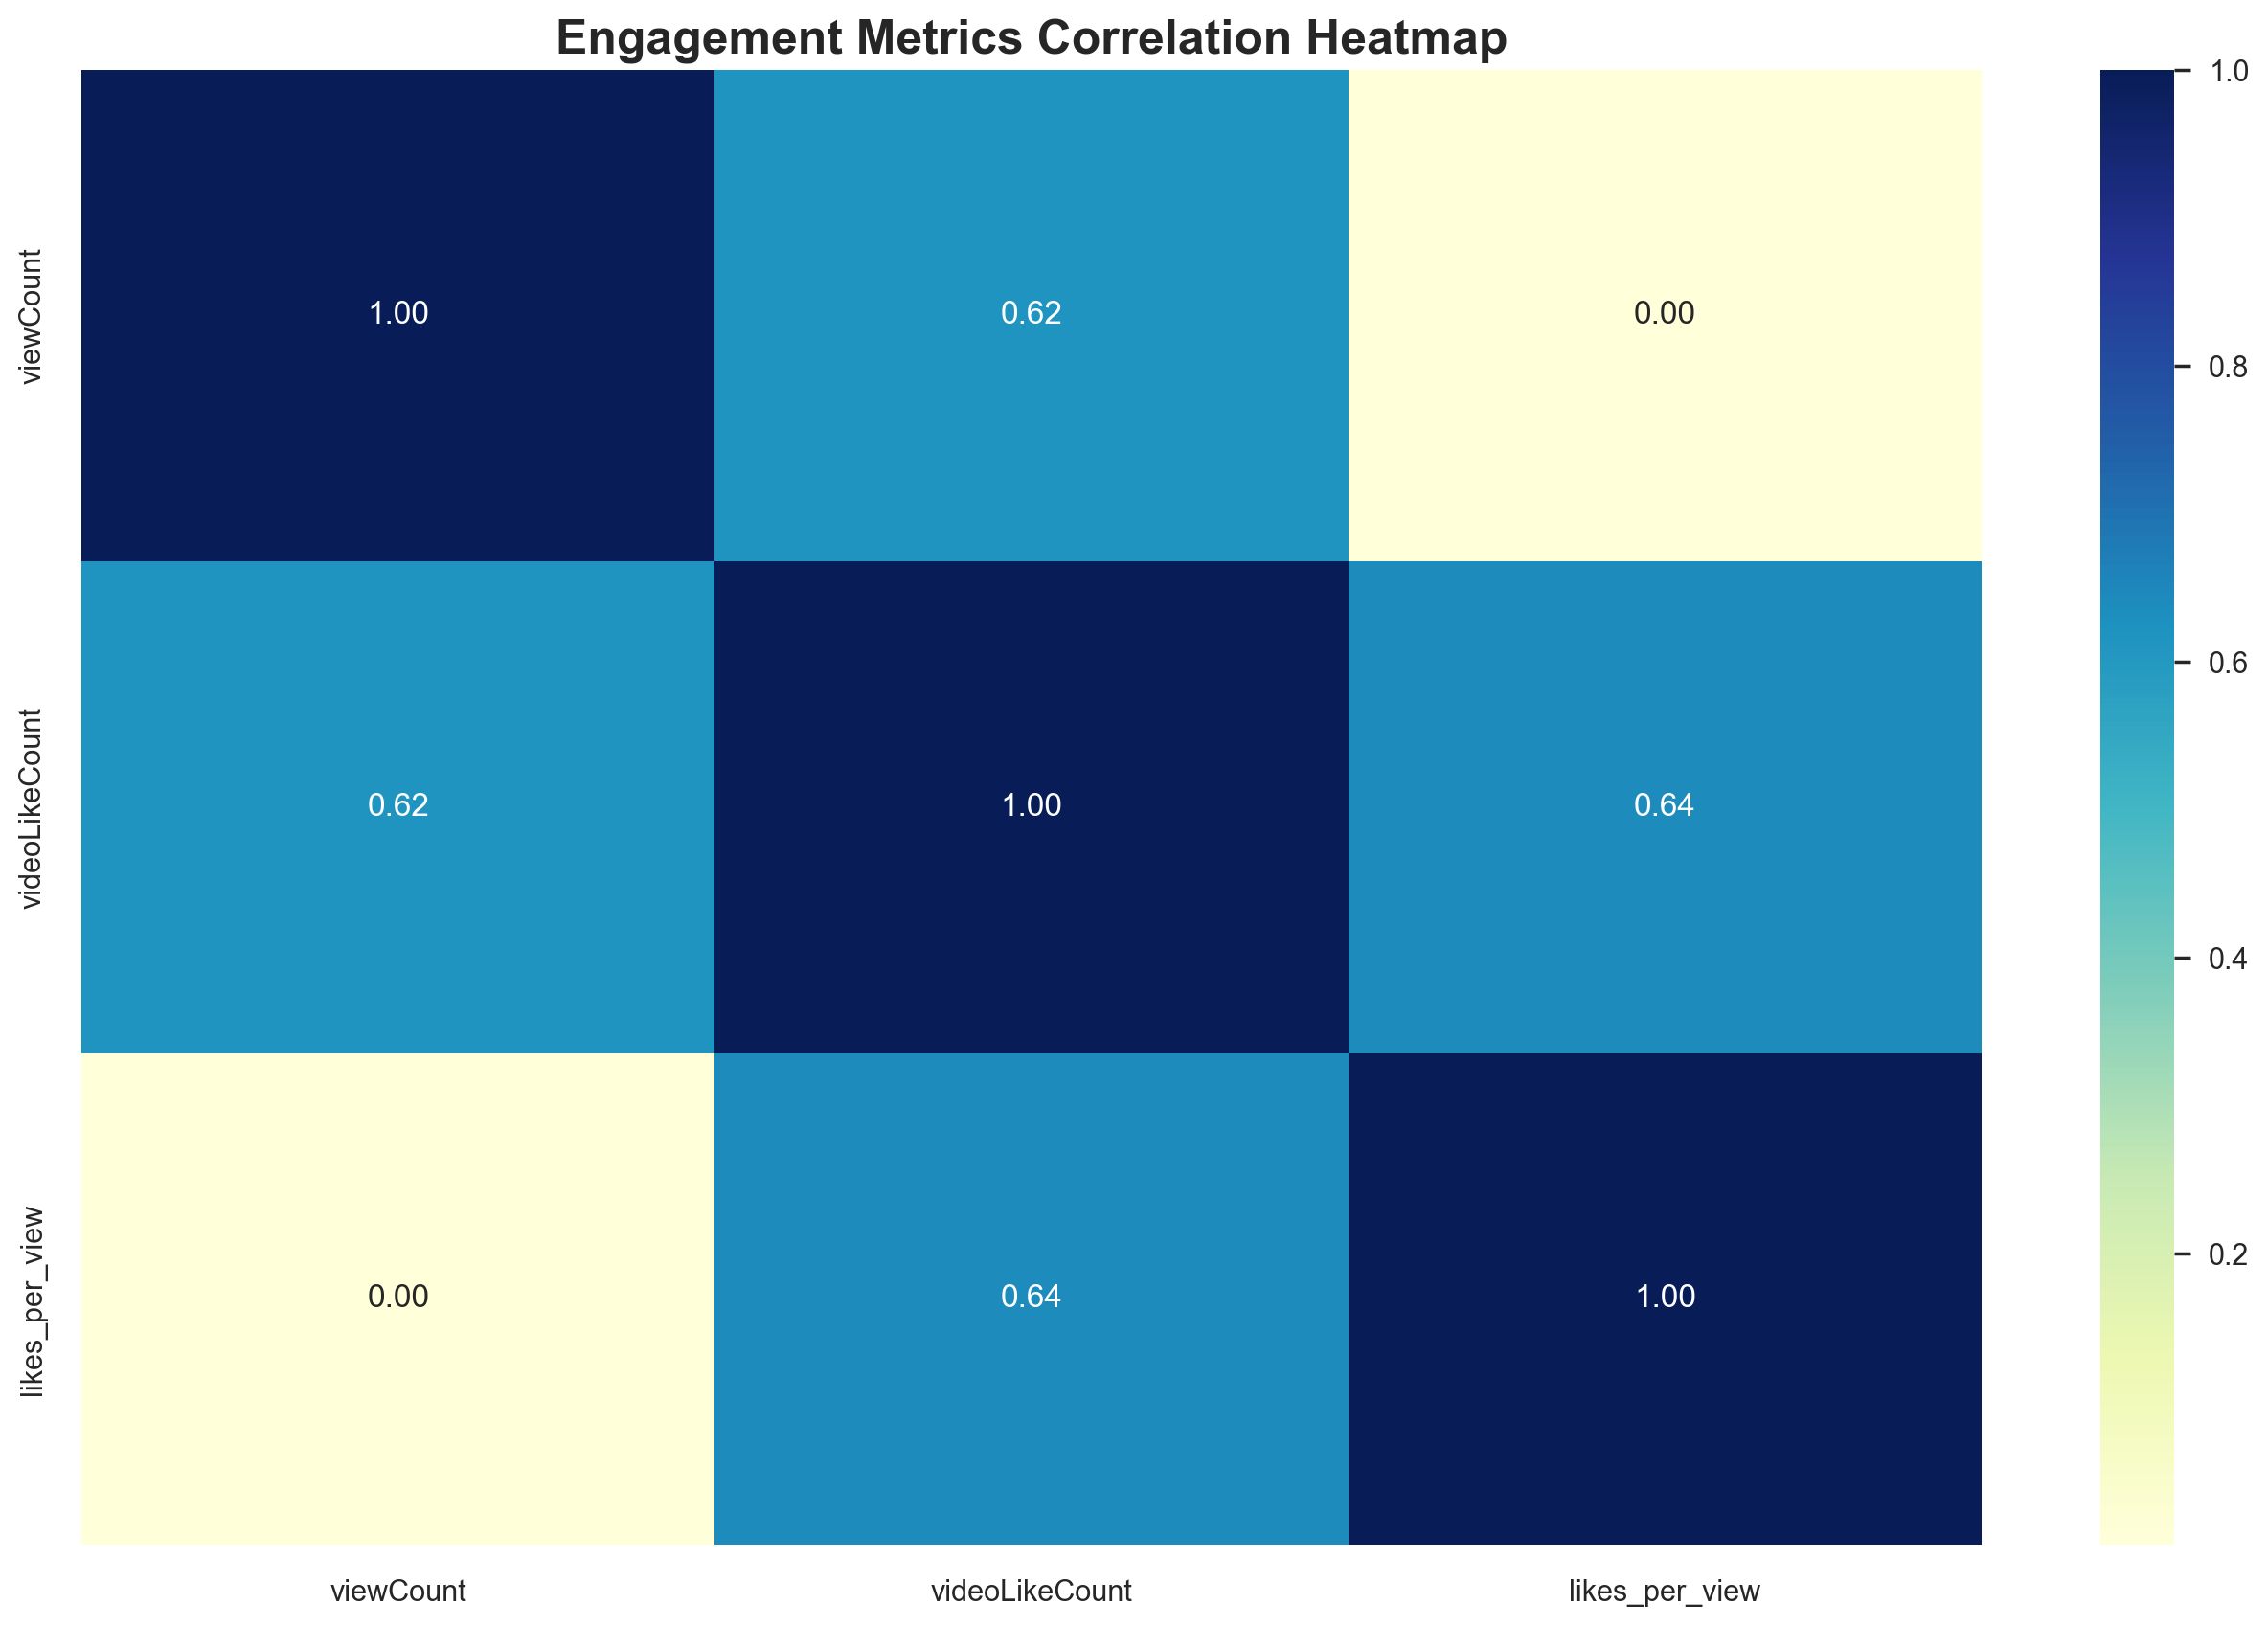

In [ ]:
# Calculate likes per view ratio
df_of_videos['likes_per_view'] = df_of_videos['videoLikeCount'] / df_of_videos['viewCount']
sns.heatmap(df_of_videos[['viewCount', 'videoLikeCount', 'likes_per_view']].corr(), 
            annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Engagement Metrics Correlation Heatmap')
plt.show()

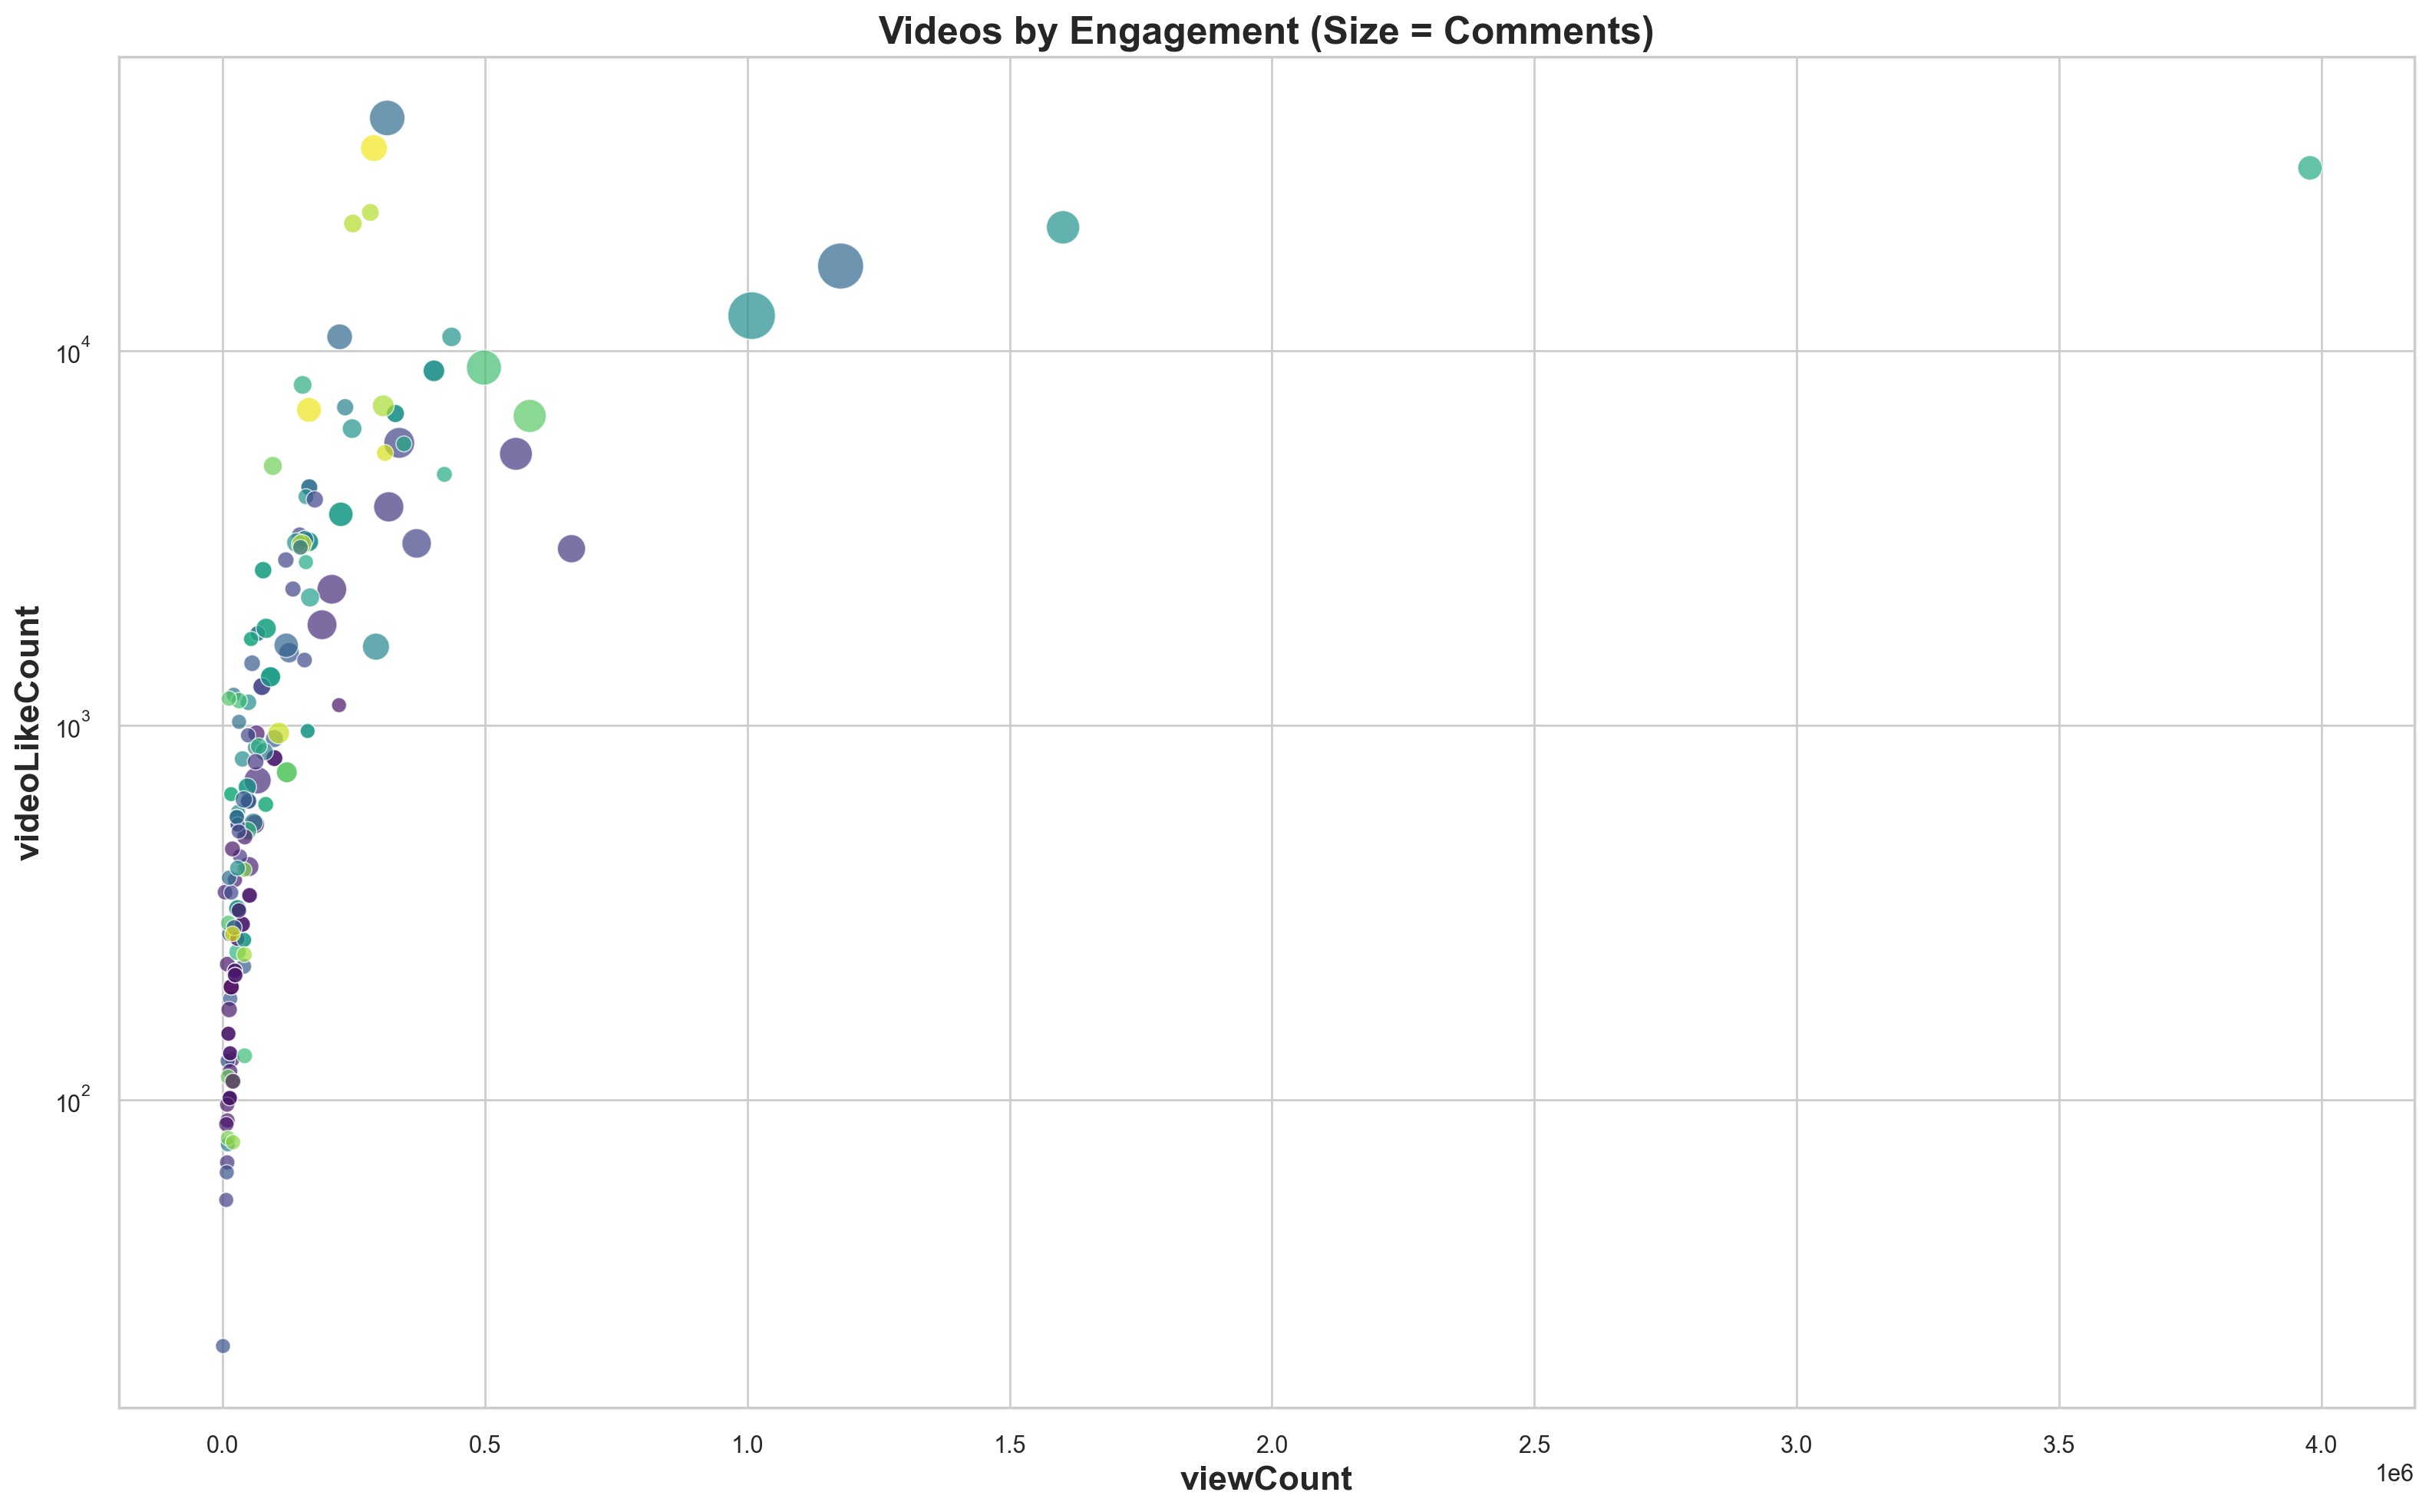

In [61]:
# Plot Video Engagement
sns.scatterplot(data=df_of_videos, x='viewCount', y='videoLikeCount', 
                size='videoCommentCount', hue='channelTitle',
                sizes=(50, 500), alpha=0.7, palette='viridis', legend=False)
plt.yscale('log')
plt.title('Videos by Engagement (Size = Comments)')
plt.tight_layout()

Text(0.5, 1.0, 'Most Frequent Tags in Videos')

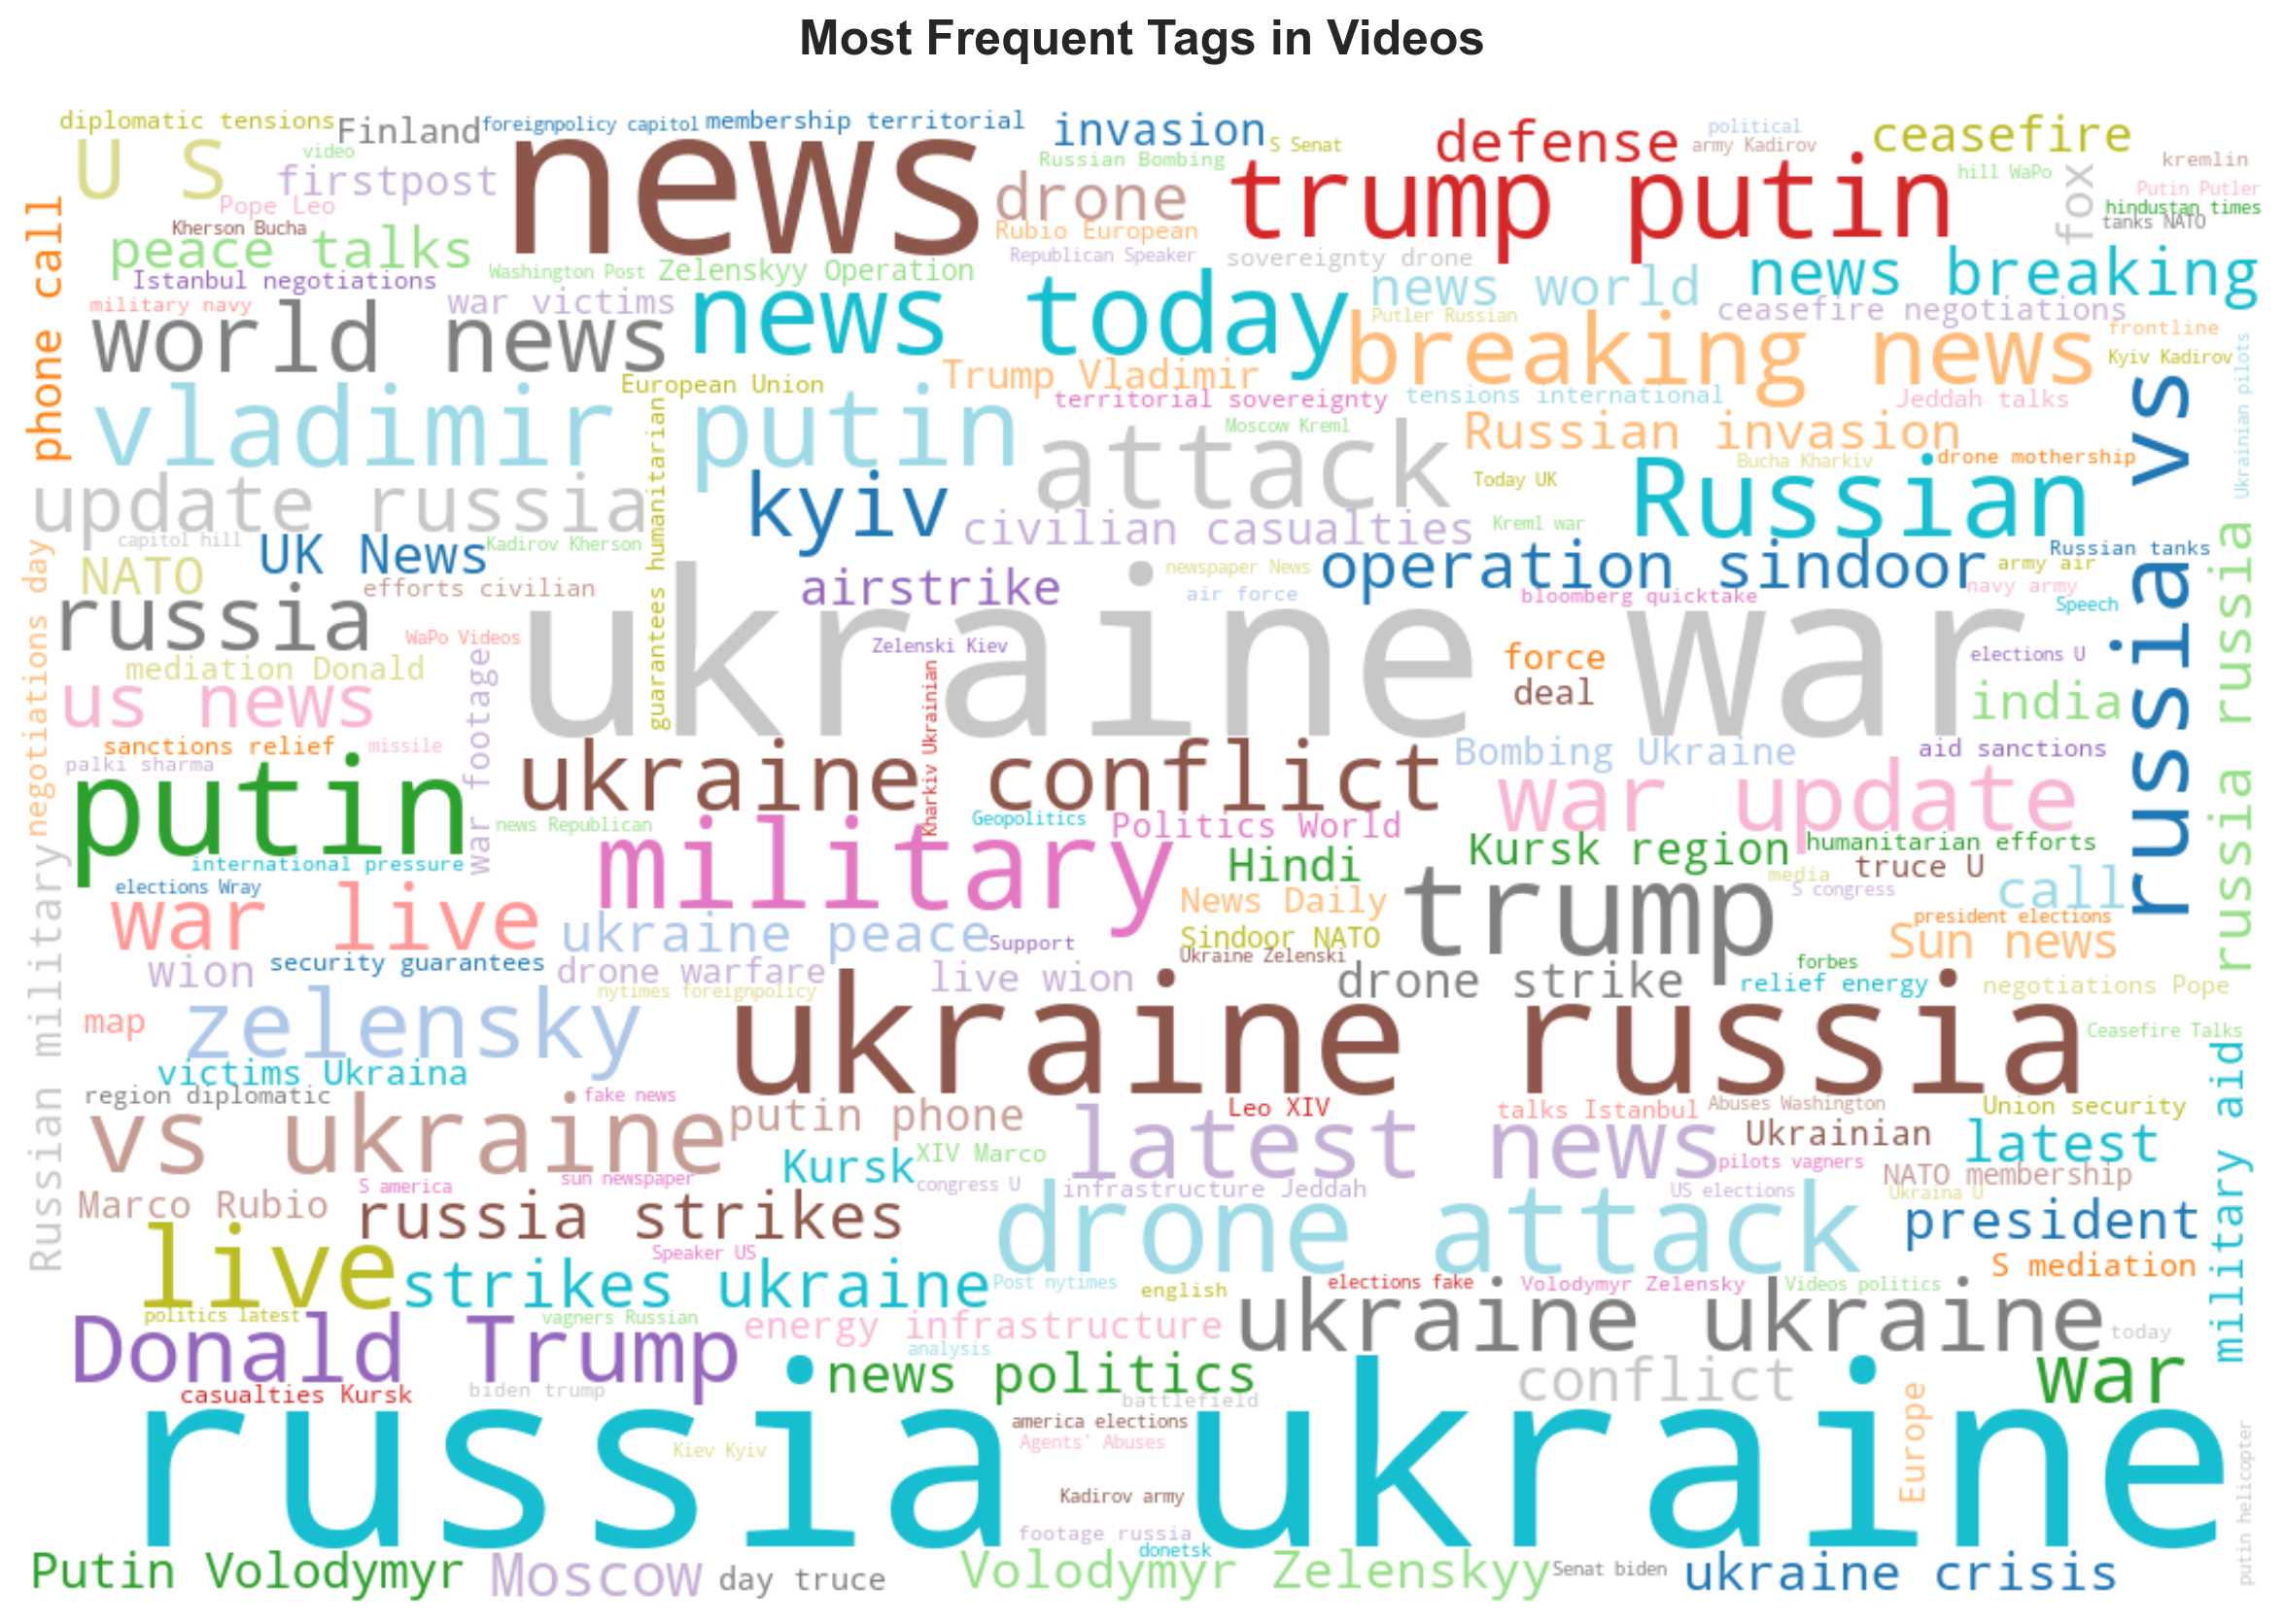

In [62]:
# Word cloud for most frequent tags
tags_text = ' '.join(df_of_videos['tags'].dropna())
wordcloud = WordCloud(width=1080, height=720, background_color='white', colormap='tab20').generate(tags_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Tags in Videos', pad=20)

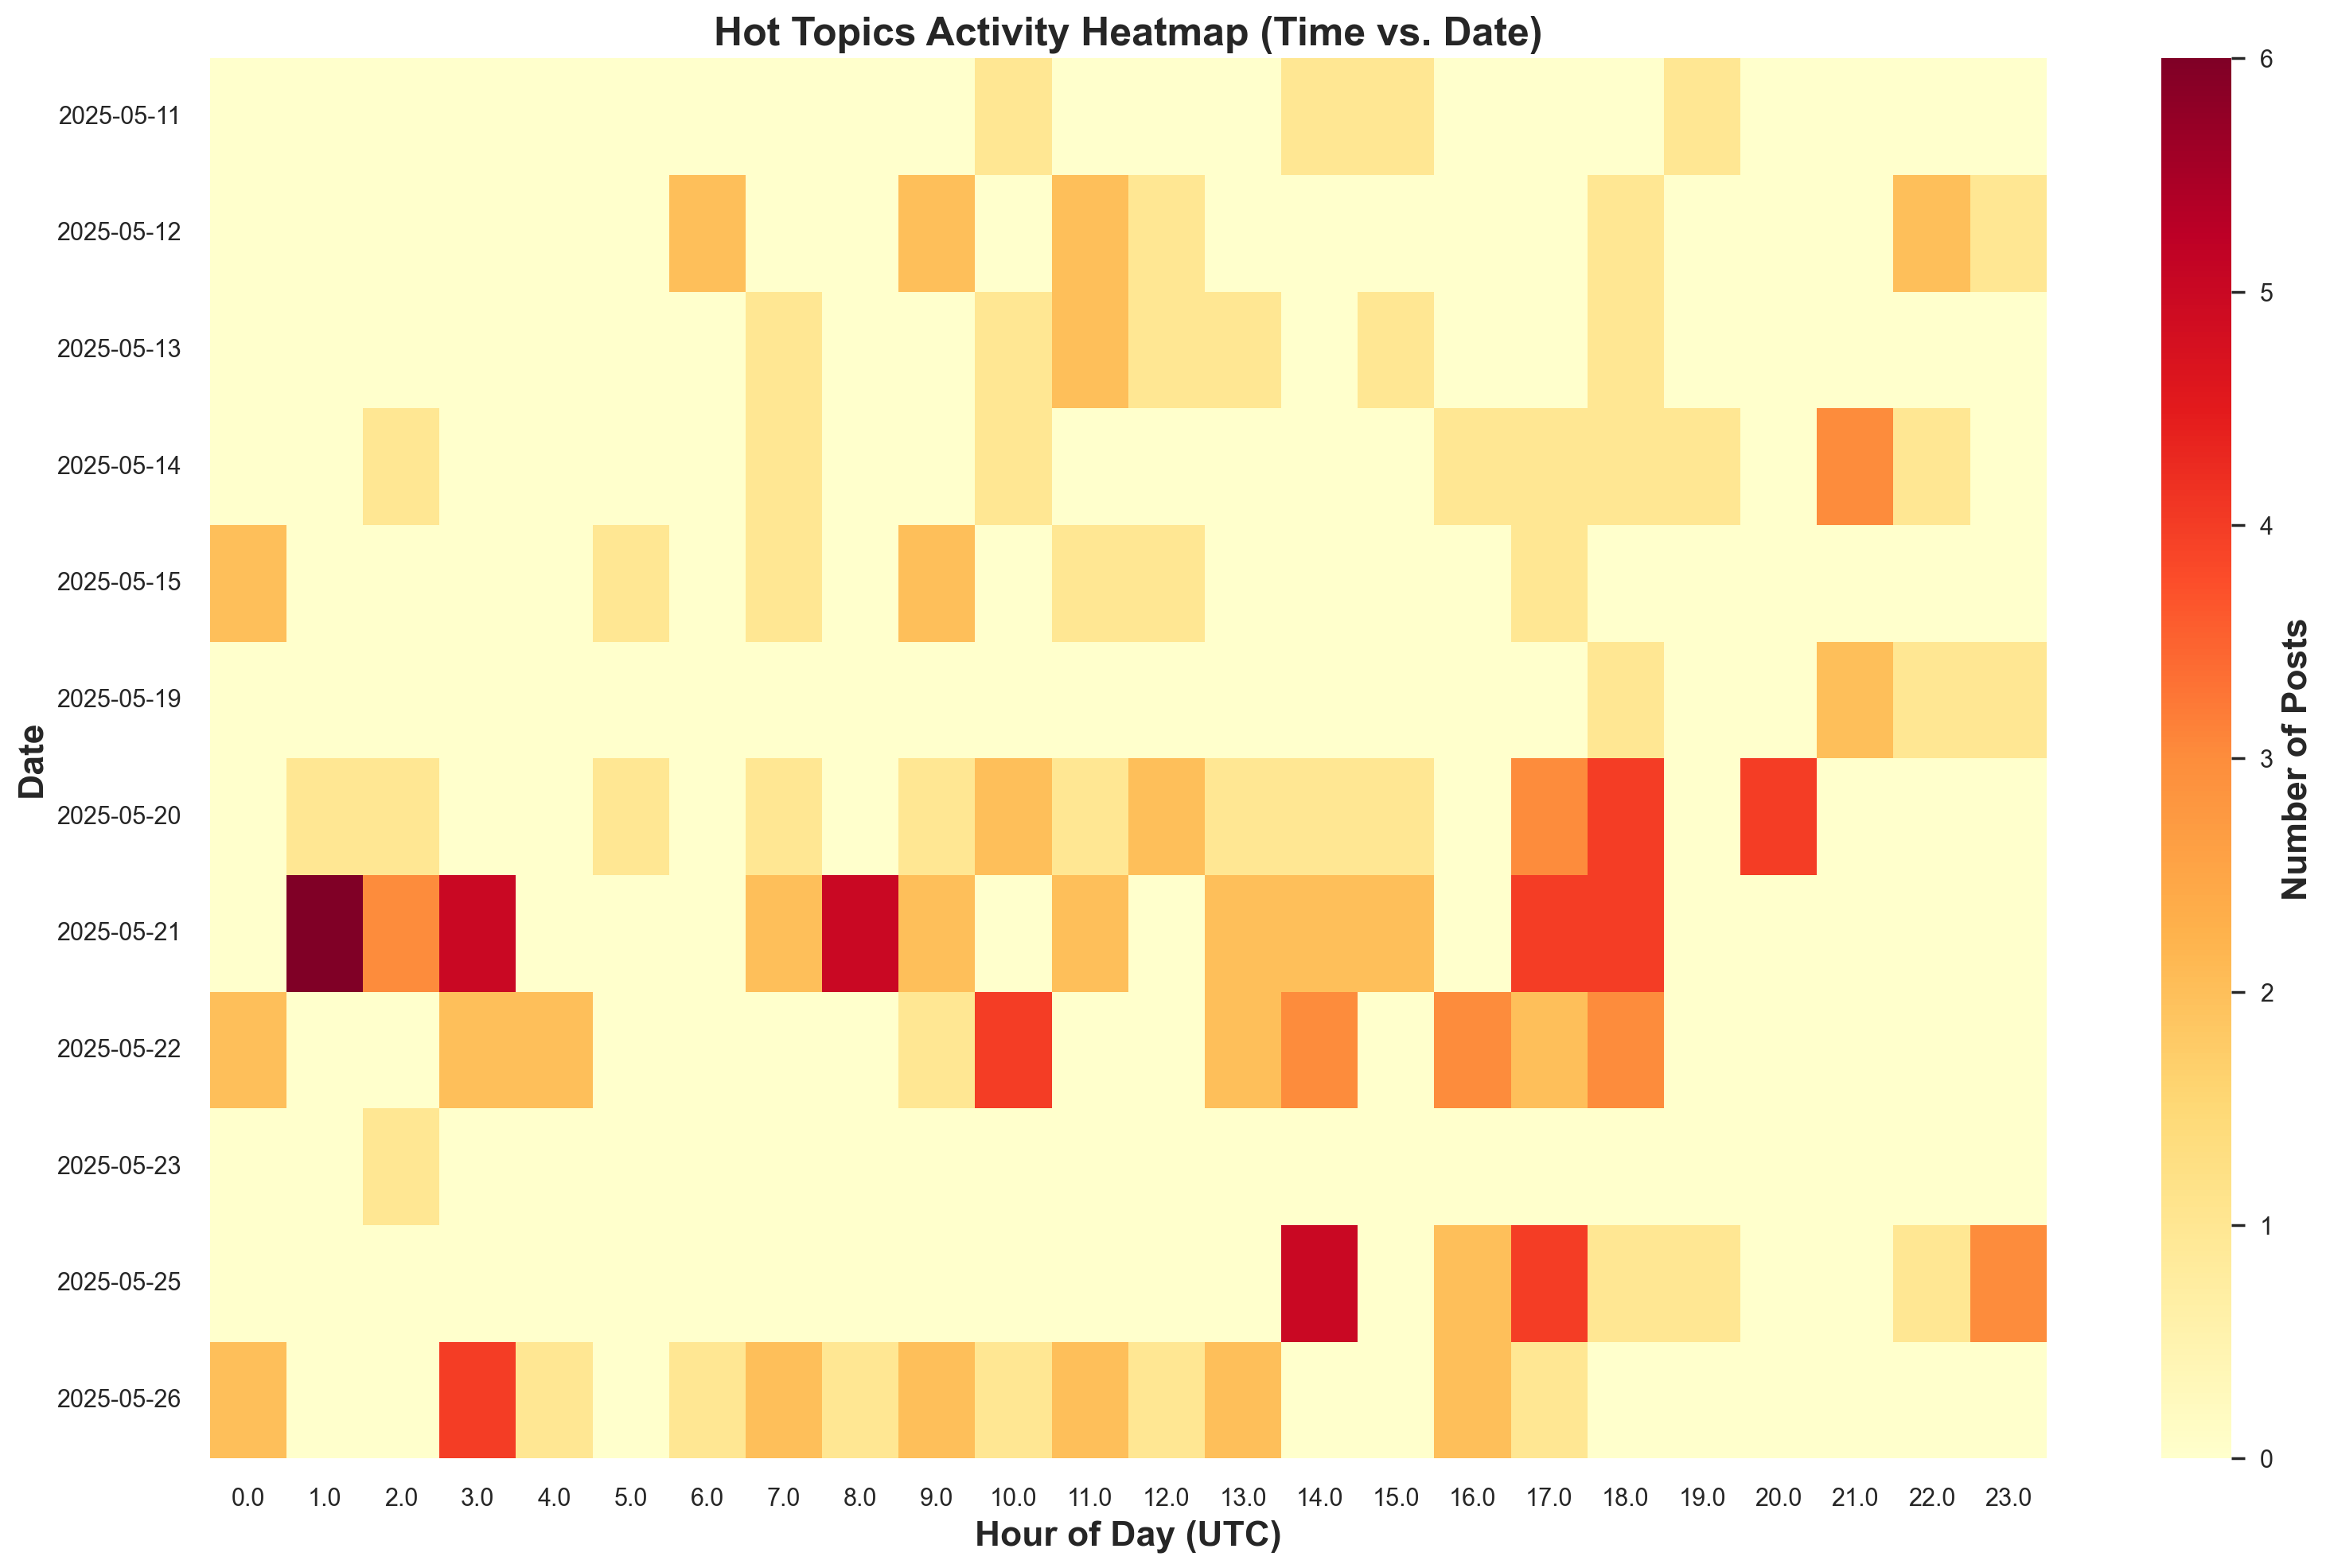

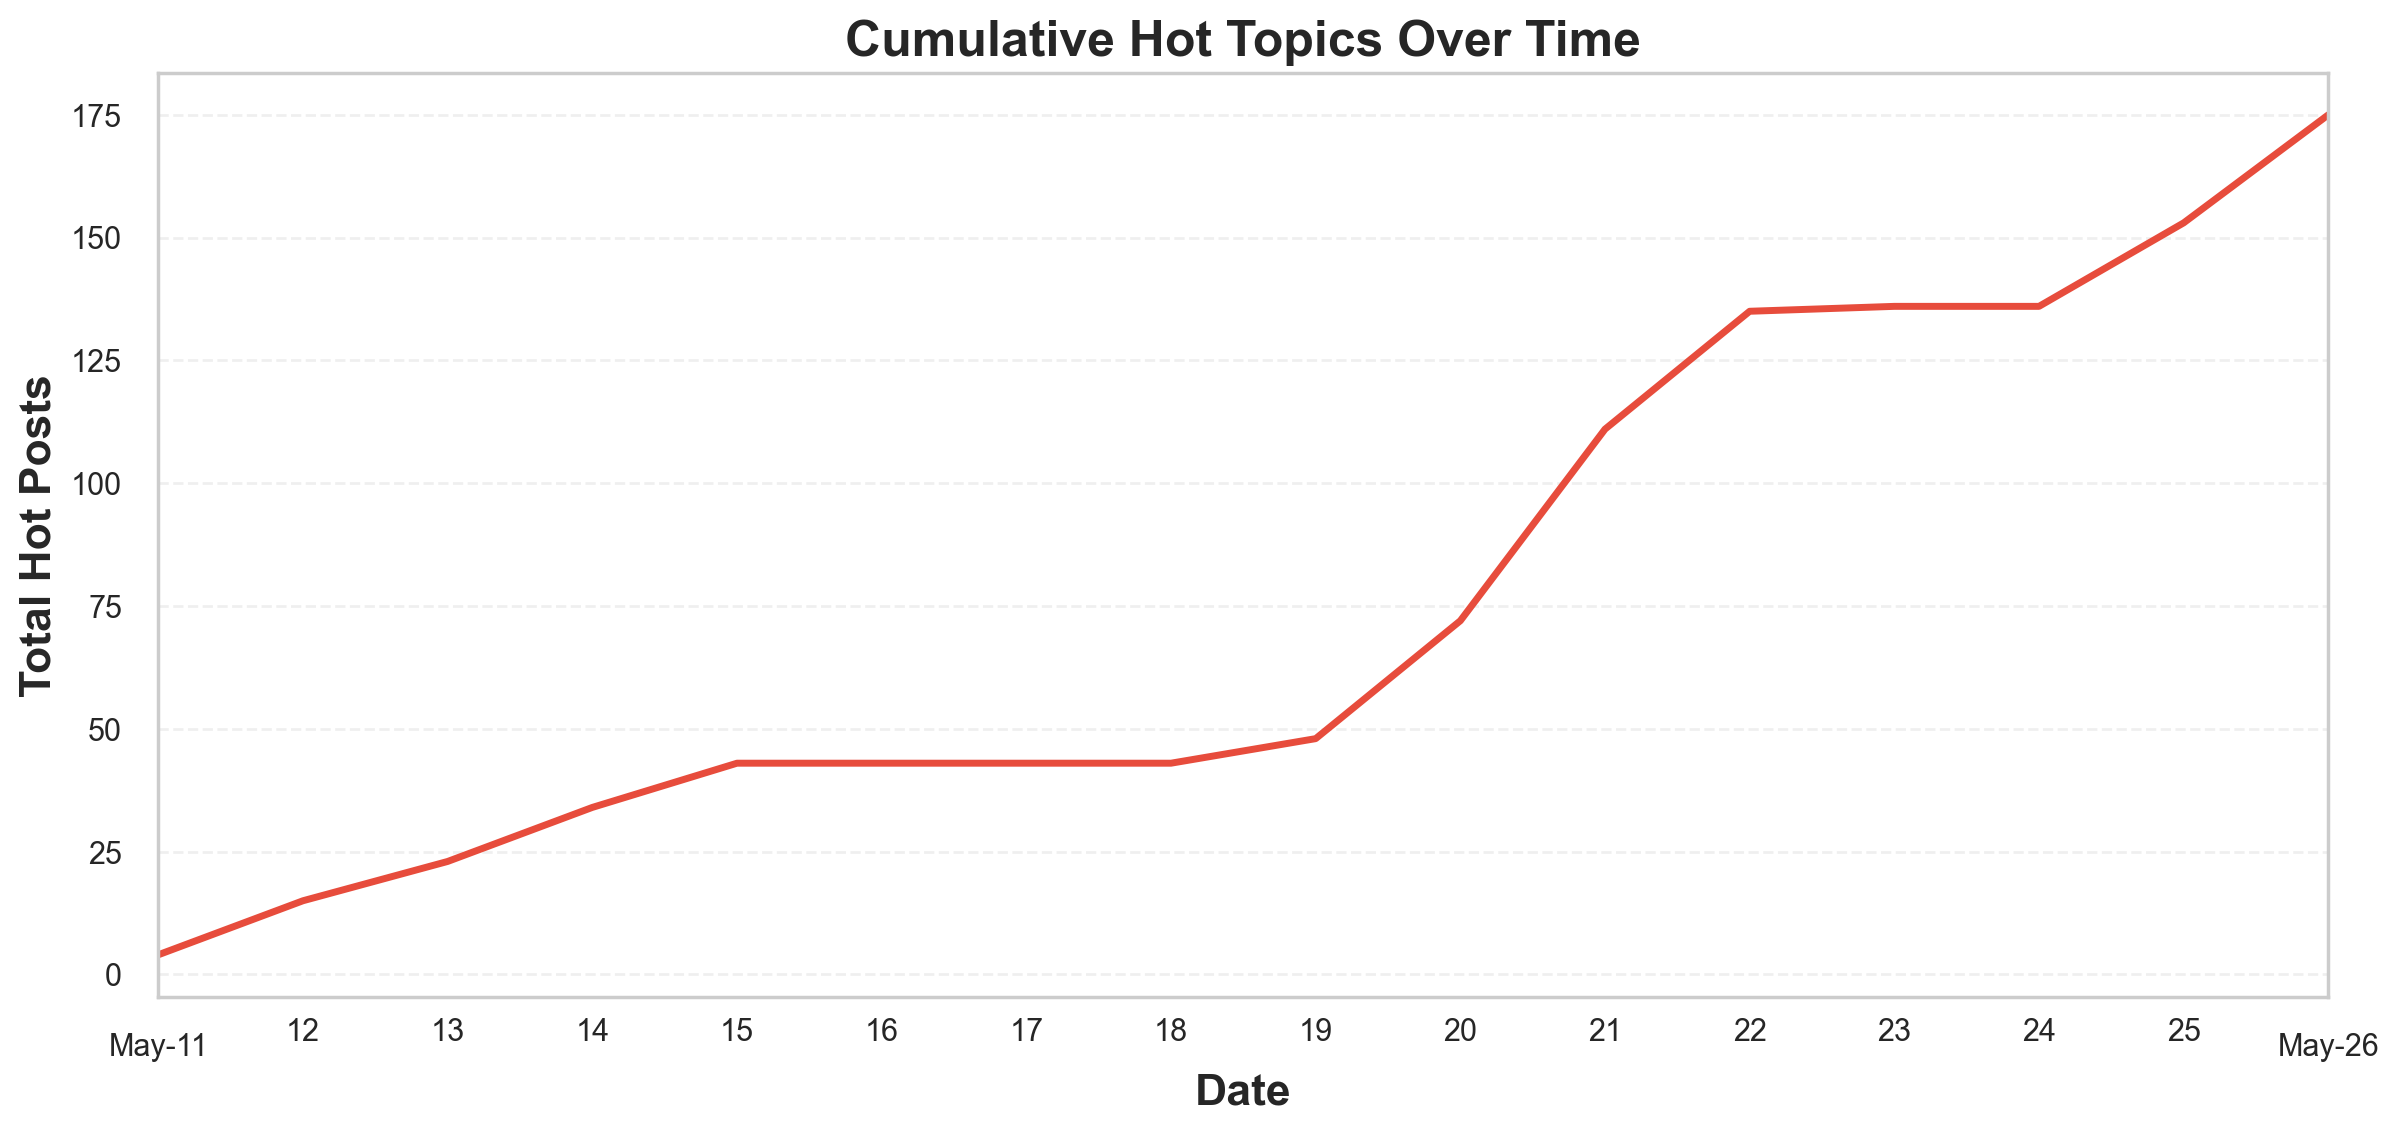

In [63]:
# Convervsion of videoPublishedAt to datetime
df_of_videos['datetime'] = pd.to_datetime(df_of_videos['videoPublishedAt'])

# Resample by day/week
daily_counts = df_of_videos.set_index('datetime').resample('D').size()

heatmap_data = df_of_videos.assign(
    hour=df_of_videos['datetime'].dt.hour,
    date=df_of_videos['datetime'].dt.date
).pivot_table(index='date', columns='hour', values='title', aggfunc='count')

# Plot heatmap
sns.heatmap(heatmap_data.fillna(0), cmap='YlOrRd', cbar_kws={'label': 'Number of Posts'})
plt.title('Hot Topics Activity Heatmap (Time vs. Date)')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

# Plot Cumulative Trend Line
plt.figure(figsize=(14, 6))
daily_counts.cumsum().plot(color='#e74c3c', linewidth=2.5)
plt.title('Cumulative Hot Topics Over Time')
plt.xlabel('Date')
plt.ylabel('Total Hot Posts')
plt.grid(True, linestyle='--', alpha=0.3)
date_form = DateFormatter("%b-%d")
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

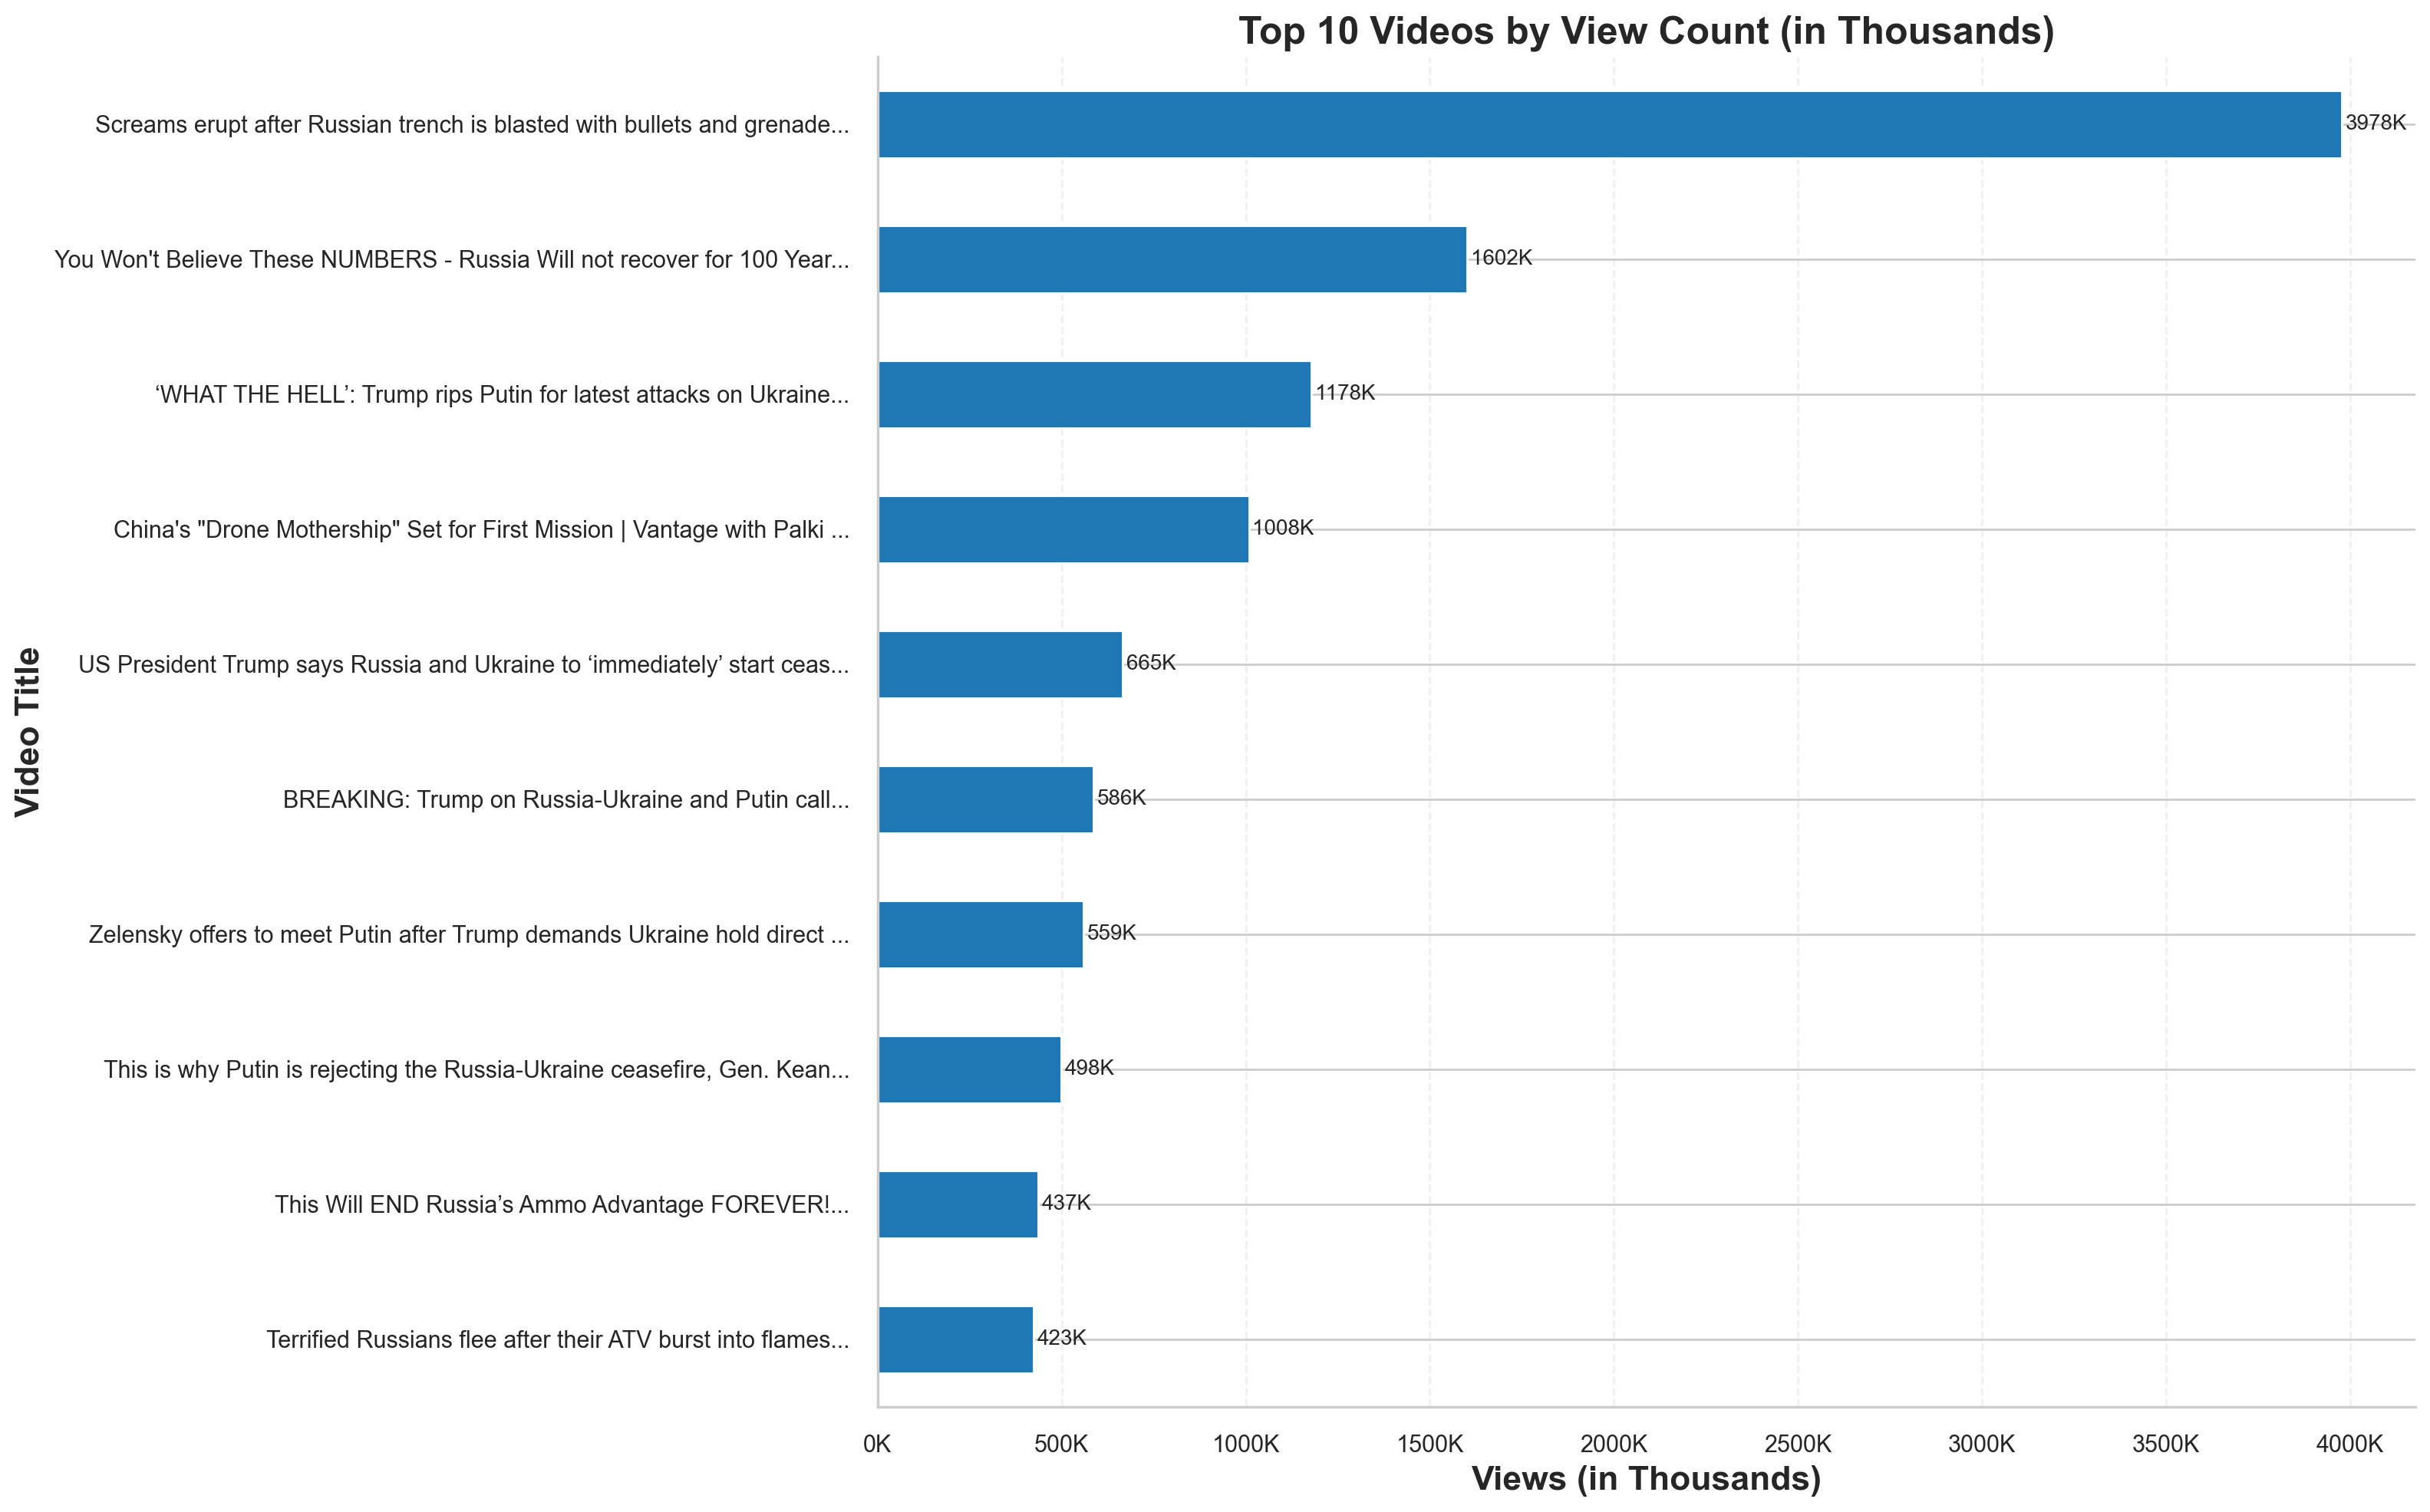

In [64]:
# Convert viewCount to numeric and get top 10 videos
df_of_videos['viewCount'] = pd.to_numeric(df_of_videos['viewCount'], errors='coerce')
top10 = (
    df_of_videos.drop_duplicates('videoId')
                .nlargest(10, 'viewCount')
                .set_index('title')['viewCount']
)
ax = top10.sort_values().plot.barh(color='#1f77b4')

# Format ALL numbers in thousands (K) 
def format_k(x, pos):
    return f'{x/1000:.0f}K'
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_k))

# Add value labels
for i, v in enumerate(top10.sort_values()):
    ax.text(v + 10000, i, f'{v/1000:.0f}K', 
            va='center', fontsize=10)

plt.title('Top 10 Videos by View Count (in Thousands)', loc='center')
plt.xlabel('Views (in Thousands)')
plt.ylabel('Video Title')
plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine()
plt.gca().set_yticklabels([label.get_text()[:70] + "..." for label in plt.gca().get_yticklabels()])
plt.tight_layout()
plt.show()

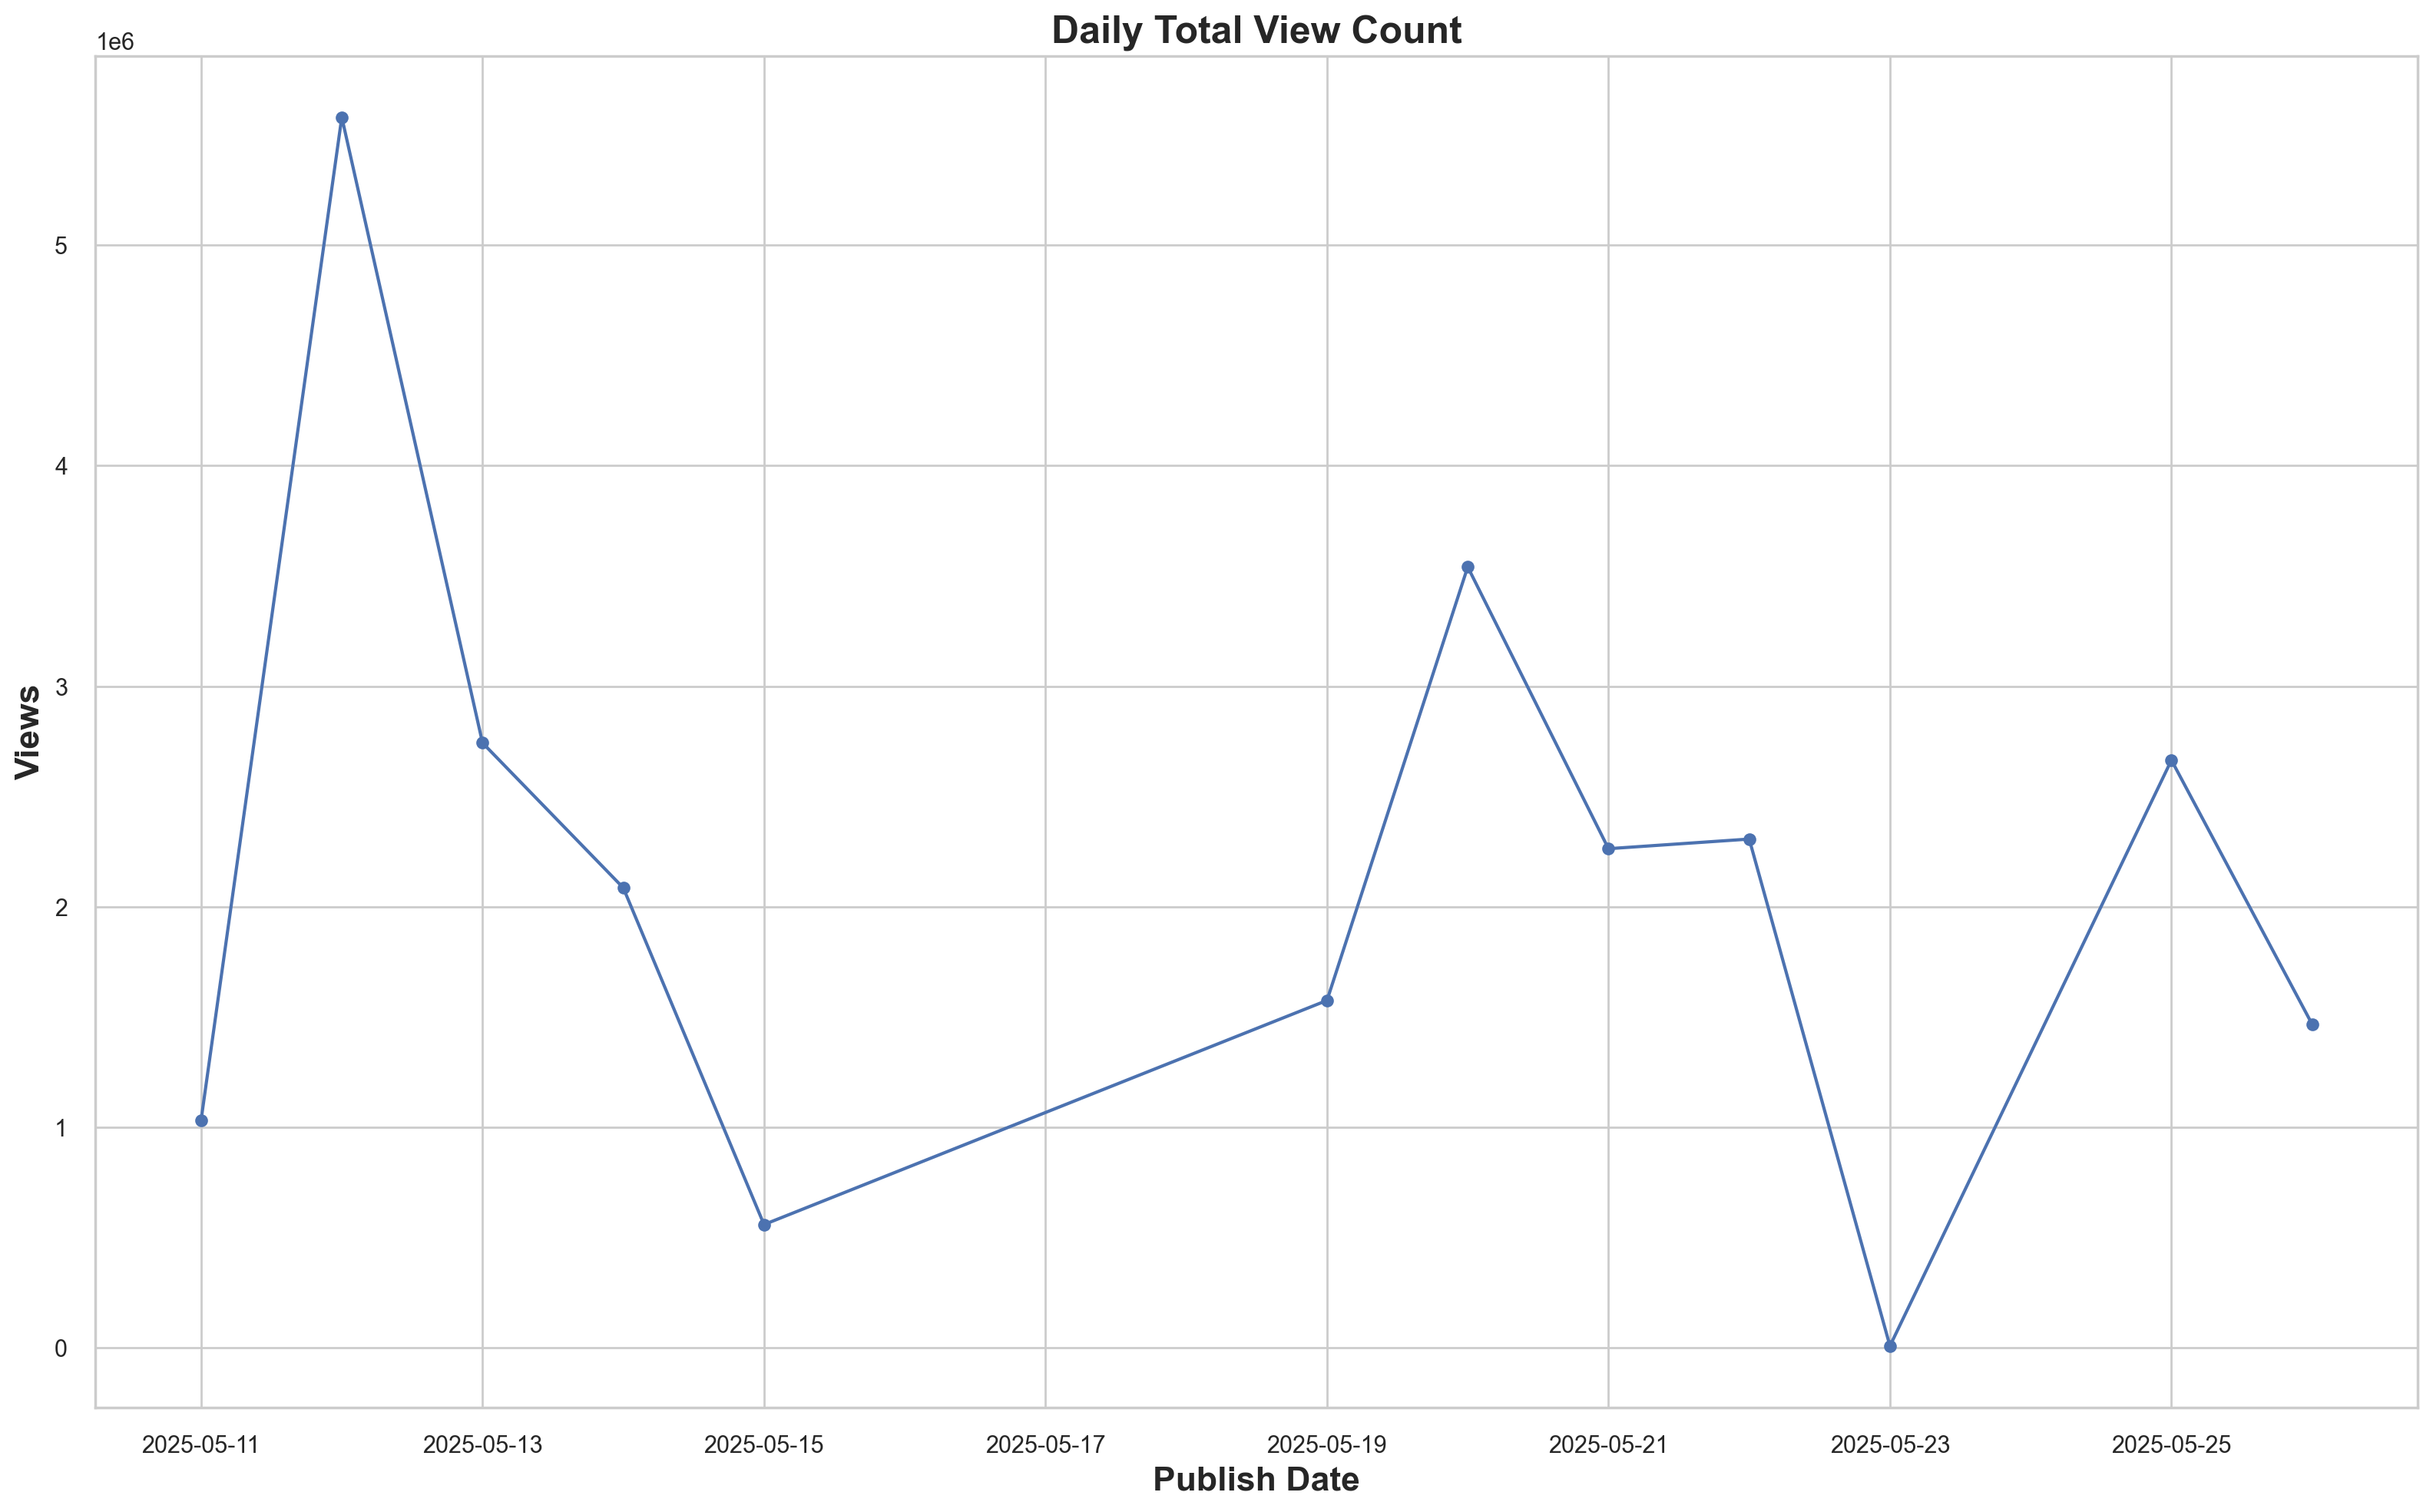

In [65]:
# Plot daily total view count
df_of_videos['videoPublishedAt'] = pd.to_datetime(df_of_videos['videoPublishedAt'])
daily_comments = (
    df_of_videos.groupby(df_of_videos['videoPublishedAt'].dt.date)
                ['viewCount']
                .agg('sum')
              
)
daily_comments.plot(marker='o')
plt.title("Daily Total View Count")
plt.xlabel("Publish Date")
plt.ylabel("Views")
plt.tight_layout()
plt.show()
